# Company Valuation

**Author:** Luis Santamaría  
**Date:** September 2, 2025  
---

## Objective  
Every investor, whether institutional or retail, faces the same timeless question: *Is this company fairly valued by the market, or does an opportunity lie hidden beneath the numbers?*  

The objective of this project is to explore that question by conducting a **comprehensive deep-dive into a single publicly traded company**. While my previous work focused on diversification and portfolio optimization, this analysis shifts the lens to one firm at a time, examining its strengths, weaknesses, and potential from every angle.  

The approach blends **market data, financial statements, and valuation models** into a coherent story of corporate performance. Historical prices, risk metrics, and peer comparisons provide the context, while balance sheets, income statements, and cash flows reveal the inner workings of the business. Ultimately, several valuation techniques—including discounted cash flow, dividend discount modeling, comparables, and asset-based valuation—are applied to estimate the company’s intrinsic worth and compare it against the market’s perception.  

---

## Research Questions  
This project asks: How does the chosen company measure up against its direct competitors and its benchmark index? What do its financial structures—debt, liquidity, margins, and cash generation—say about resilience and growth prospects? When we apply different valuation frameworks, do they converge toward the same conclusion, or do they reveal discrepancies that highlight uncertainty? Most importantly, is there a clear mispricing between the intrinsic value suggested by fundamentals and the price at which the market currently trades?  

---

## Working Hypotheses  
The working premise is that **markets are not always perfectly efficient**. Momentum-driven stocks can be pushed to valuations that ignore fundamentals, while less glamorous companies may quietly generate value beneath the radar. Sector norms also play a role: a price-to-earnings ratio that looks excessive in utilities might be standard in technology. Healthy balance sheets should correlate with greater resilience, while dividend policies may act as signals of confidence in future cash flows. Finally, no single valuation method tells the entire story—only by triangulating different approaches can a more balanced view of intrinsic value emerge.  

---

## Scope and Limitations  
This analysis draws on real-time and historical data from Yahoo Finance, focusing on companies listed in the **S&P 500 (United States)**, the **S&P/BMV IPC (Mexico)**, and the **Ibovespa (Brazil)**. For each selected ticker, both market performance and financial fundamentals are collected and analyzed. Coverage typically spans the past five to ten years, though availability varies.  

It is important to recognize the boundaries of this work. Financial data is subject to reporting lags and revisions; survivorship bias favors currently listed companies; and the assumptions behind valuation models—such as discount rates or growth expectations—heavily influence outcomes. Furthermore, broader macroeconomic conditions like interest rates, inflation, or geopolitical risk remain outside the scope of this project, even though they inevitably shape valuation in practice.  

With these constraints acknowledged, the analysis aims not to deliver a definitive “buy” or “sell” signal, but to provide a **clear, data-driven narrative** of how a company’s market value compares to its intrinsic worth, and why that difference may matter to investors.  

# 1. Company Selection  

Every journey into valuation begins with a universe of possibilities. In our case, that universe is defined by three powerful markets: the **S&P 500 in the United States**, the **S&P/BMV IPC in Mexico**, and the **Ibovespa in Brazil**. Together, they capture both developed and emerging economies, offering a balanced stage for comparison.  

Our CSV file serves as a *map* of this universe. Each row represents a company, identified by its raw trading symbol, its official name, the index it belongs to, and the specific Yahoo Finance ticker that will allow us to retrieve data. In this way, the dataset is not just a static list—it is a living gateway to financial markets.  

The analysis truly begins when the user, acting as an analyst, chooses a ticker. This single decision transforms the dataset into a story about one company. By entering a symbol, we immediately connect to Yahoo Finance, download the company’s profile, and, whenever possible, even display its logo. At that moment, the abstract turns tangible: a name, a sector, a market capitalization, and a brand identity.  

From here, every chart, ratio, and model will revolve around this choice. This first step is simple but decisive—it sets the stage for the deep dive that follows.  

In [3]:
import pandas as pd
import yfinance as yf

companies = pd.read_csv("companies_list.csv")
companies["ticker"] = companies["ticker"].astype(str).str.upper().str.strip()

ticker = input("Enter the Yahoo Finance ticker of the company you want to analyze: ").strip().upper()

if ticker not in companies["ticker"].values:
    prefix = ticker[:2]
    candidates = companies.loc[companies["ticker"].str.startswith(prefix), "ticker"].unique()[:12]
    suggestion = f" Close matches: {', '.join(candidates)}" if len(candidates) else ""
    raise ValueError(f"Ticker {ticker} not found in companies_list.csv.{suggestion}")

row = companies.loc[companies["ticker"] == ticker].iloc[0]
company_index  = str(row["index"])
company_sector = str(row["sector"]) if pd.notna(row["sector"]) else None
company_name   = str(row["name"])

stock = yf.Ticker(ticker)
try:
    info = stock.info
except Exception:
    info = {}

long_name = info.get("longName", company_name)
sector    = info.get("sector", company_sector) or "N/A"
industry  = info.get("industry", "N/A")
marketcap = info.get("marketCap", "N/A")

currency = None
try:
    currency = getattr(stock, "fast_info", {}).get("currency", None)
except Exception:
    pass
if currency is None:
    currency = info.get("currency", "N/A")

print("=" * 50)
print(f"Selected Company: {long_name}")
print(f"Ticker: {ticker}")
print(f"Index:  {company_index}")
print(f"Sector: {sector}")
print(f"Industry: {industry}")
print(f"Market Cap: {marketcap}")
print(f"Currency: {currency}")
print("=" * 50)

Enter the Yahoo Finance ticker of the company you want to analyze: PETR4.SA
Selected Company: Petróleo Brasileiro S.A. - Petrobras
Ticker: PETR4.SA
Index:  IBOV
Sector: Energy
Industry: Oil & Gas Integrated
Market Cap: 421980635136
Currency: BRL


# 2. Price History & Market Performance

Before diving into ratios and financial statements, we first listen to what the market has been saying about this company. Price is not the whole story—but it *is* the story the market tells in real time. By tracing the equity’s path over the last five years and comparing it to a relevant benchmark, we get an immediate sense of regime changes, momentum, volatility, and how the business has been rewarded (or punished) by investors.

In this section, we reconstruct that path with adjusted prices (including corporate actions), transform them into daily returns, and let the data speak through a handful of essential diagnostics: cumulative performance, drawdowns (how deep and how often the stock fell from prior peaks), and risk metrics such as volatility and beta versus its home index.  

A single chart rarely decides an investment, but it frames the questions we’ll ask from here on: *Was the stock merely riding a rising tide? Did it outperform through a downturn? Are sharp rallies offset by equally sharp collapses?* With these answers, the later fundamentals and valuation work gain context—and the narrative starts to take shape.

Index: IBOV | Sector: Energy | Benchmark: ^BVSP


,Value
CAGR (asset),0.384355
Volatility (asset),0.318404
Sharpe (rf=0%),1.207130
Beta vs Benchmark,1.037352
Max Drawdown (asset),-0.391042
CAGR (cohort),0.102762
Volatility (cohort),0.293116
"Sharpe (cohort, rf=0%)",0.350583
CAGR (benchmark),0.036400


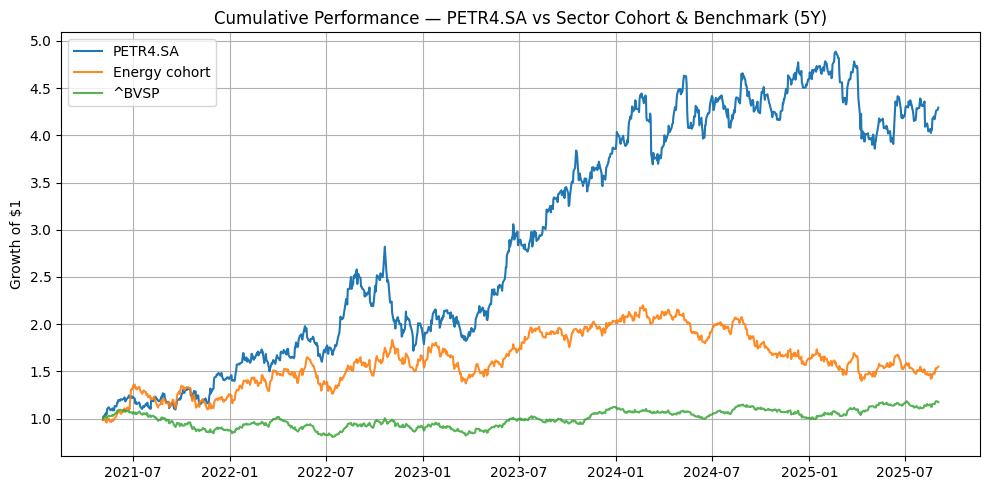

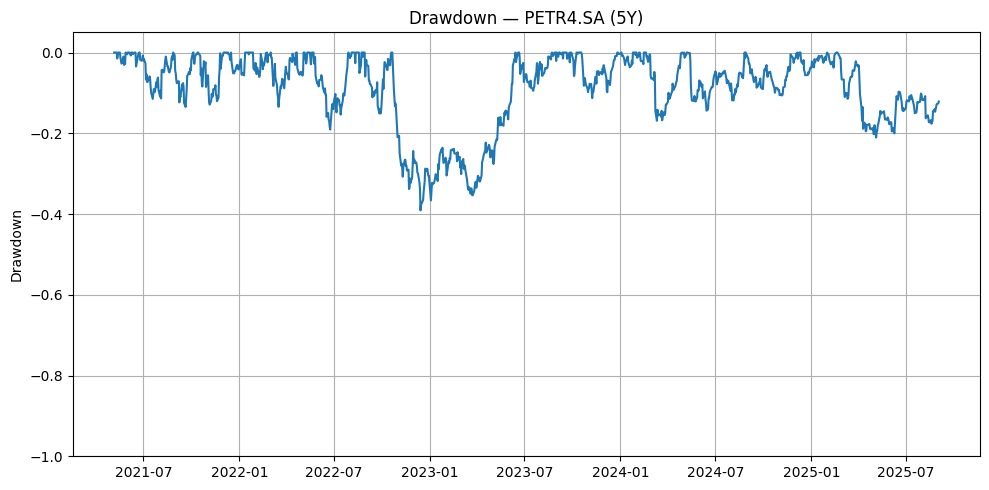

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from IPython.display import display

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

row = companies.loc[companies["ticker"] == ticker]
if row.empty:
    raise ValueError(f"Ticker {ticker} not found in companies list.")

company_index  = str(row["index"].iloc[0])
company_sector = row["sector"].iloc[0] if pd.notna(row["sector"].iloc[0]) else None

BENCHMARK_MAP = {
    "SP500": "^GSPC",
    "IPC": "^MXX",
    "IBOV": "^BVSP"
}
benchmark_ticker = BENCHMARK_MAP.get(company_index.upper(), "^GSPC")
print(f"Index: {company_index} | Sector: {company_sector or 'N/A'} | Benchmark: {benchmark_ticker}")

peers_df = companies[
    (companies["index"].str.upper() == company_index.upper()) &
    (companies["sector"] == company_sector) &
    (companies["ticker"] != ticker)
]
peer_tickers = peers_df["ticker"].dropna().str.upper().unique().tolist()[:15]
if not peer_tickers:
    print("[info] No same-sector peers found in this index. Cohort will be omitted.")

symbols = [ticker, benchmark_ticker] + peer_tickers
hist = yf.download(symbols, period="5y", interval="1d", auto_adjust=True, progress=False)

if isinstance(hist.columns, pd.MultiIndex):
    px = hist["Close"]
else:
    px = hist[["Close"]].rename(columns={"Close": ticker})

px = px.asfreq("B").ffill().dropna(how="all")

available = [c for c in [ticker, benchmark_ticker] + peer_tickers if c in px.columns]
if ticker not in available:
    raise RuntimeError(f"Price series for {ticker} not available.")
peer_tickers = [t for t in peer_tickers if t in available]
has_bench = benchmark_ticker in available

rets = px[available].pct_change().dropna()

r_asset = rets[ticker]
r_bench = rets[benchmark_ticker] if has_bench else None
r_cohort = rets[peer_tickers].mean(axis=1) if peer_tickers else None

cum_asset  = (1 + r_asset).cumprod()
cum_bench  = (1 + r_bench).cumprod() if r_bench is not None else None
cum_cohort = (1 + r_cohort).cumprod() if r_cohort is not None else None

def drawdown(series: pd.Series) -> pd.Series:
    peak = series.cummax()
    return series / peak - 1.0

dd_asset = drawdown(cum_asset)

N = 252

def ann_return(r: pd.Series) -> float:
    if r is None or r.empty: return np.nan
    g = (1 + r).prod()
    years = len(r) / N
    return g**(1/years) - 1 if years > 0 else np.nan

def ann_vol(r: pd.Series) -> float:
    if r is None or r.empty: return np.nan
    return r.std() * np.sqrt(N)

def sharpe(r: pd.Series, rf: float = 0.0) -> float:
    mu = ann_return(r) - rf
    sig = ann_vol(r)
    return mu / sig if sig and not np.isnan(sig) and sig != 0 else np.nan

def beta_vs(r: pd.Series, rb: pd.Series) -> float:
    if r is None or rb is None: return np.nan
    df = pd.concat([r, rb], axis=1).dropna()
    if len(df) < 2: return np.nan
    cov = np.cov(df.iloc[:,0], df.iloc[:,1])[0,1]
    var_b = np.var(df.iloc[:,1])
    return cov / var_b if var_b != 0 else np.nan

def max_drawdown(series: pd.Series) -> float:
    return drawdown(series).min() if series is not None and not series.empty else np.nan

stats = {
    "CAGR (asset)": ann_return(r_asset),
    "Volatility (asset)": ann_vol(r_asset),
    "Sharpe (rf=0%)": sharpe(r_asset, 0.0),
    "Beta vs Benchmark": beta_vs(r_asset, r_bench),
    "Max Drawdown (asset)": max_drawdown(cum_asset),
    "CAGR (cohort)": ann_return(r_cohort),
    "Volatility (cohort)": ann_vol(r_cohort),
    "Sharpe (cohort, rf=0%)": sharpe(r_cohort, 0.0),
    "CAGR (benchmark)": ann_return(r_bench),
}

stats_df = pd.DataFrame(stats, index=["Value"]).T
display(stats_df.style.format({
    "CAGR (asset)": "{:.2%}",
    "Volatility (asset)": "{:.2%}",
    "Sharpe (rf=0%)": "{:.2f}",
    "Beta vs Benchmark": "{:.2f}",
    "Max Drawdown (asset)": "{:.2%}",
    "CAGR (cohort)": "{:.2%}",
    "Volatility (cohort)": "{:.2%}",
    "Sharpe (cohort, rf=0%)": "{:.2f}",
    "CAGR (benchmark)": "{:.2%}",
}))

fig, ax = plt.subplots()
ax.plot(cum_asset.index, cum_asset.values, label=ticker)
if cum_cohort is not None:
    ax.plot(cum_cohort.index, cum_cohort.values, label=f"{company_sector} cohort", alpha=0.9)
if cum_bench is not None:
    ax.plot(cum_bench.index, cum_bench.values, label=benchmark_ticker, alpha=0.8)
ax.set_title(f"Cumulative Performance — {ticker} vs Sector Cohort & Benchmark (5Y)")
ax.set_ylabel("Growth of $1")
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.plot(dd_asset.index, dd_asset.values, label=f"{ticker} Drawdown")
ax.set_title(f"Drawdown — {ticker} (5Y)")
ax.set_ylim(-1.0, 0.05)
ax.set_ylabel("Drawdown")
plt.tight_layout()
plt.show()

# 3. Valuation Ratios

Numbers tell stories, but valuation ratios turn those stories into comparisons. A company’s raw earnings, assets, and dividends may be large or small on an absolute scale, yet the real question is always *“relative to what?”* Ratios place companies side by side, making it possible to judge whether a stock looks expensive, cheap, or fairly priced compared to its peers and to the broader market.  

In this section, we extract key valuation multiples—**Price-to-Earnings (P/E), Price-to-Book (P/B), Price-to-Sales (P/S), EV/EBITDA, and Dividend Yield**—for the selected company. Each of these ratios highlights a different facet of the firm’s value:  
- **P/E** reflects how much investors pay for each dollar of earnings.  
- **P/B** compares the market’s valuation to the accounting book value of equity.  
- **P/S** places price in the context of sales, useful when profits fluctuate.  
- **EV/EBITDA** balances enterprise value against operating performance, accounting for debt.  
- **Dividend Yield** signals how much cash return shareholders receive relative to price.  

To give these numbers meaning, we also bring in a **set of competitors** from the same index and sector, creating a peer group benchmark. With simple charts and tables, we can see whether the company stands as an outlier, a market darling priced for perfection, or a laggard that the market may be underestimating.  

This comparative lens sharpens the narrative: fundamentals may be sound, but valuation ratios reveal how much optimism—or skepticism—the market has already priced in.

Peer cohort → index: IBOV | sector: Energy | peers: 6


,P/E (TTM),P/E (Fwd),P/B,P/S (TTM),EV/EBITDA,EV/Sales,Dividend Yield (%)
PETR4.SA,5.38,3.90,5.52,4.93,13.85,5.06,1183.00
Q1 (25%),5.19,3.07,0.95,0.43,6.66,1.66,380.00
Median,5.82,3.81,1.24,1.03,6.89,2.46,562.00
Q3 (75%),5.88,4.57,1.54,1.90,7.15,3.28,686.00


,Company percentile vs peers
P/E (TTM),40%
P/E (Fwd),50%
P/B,83%
P/S (TTM),83%
EV/EBITDA,83%
EV/Sales,83%
Dividend Yield (%),100%


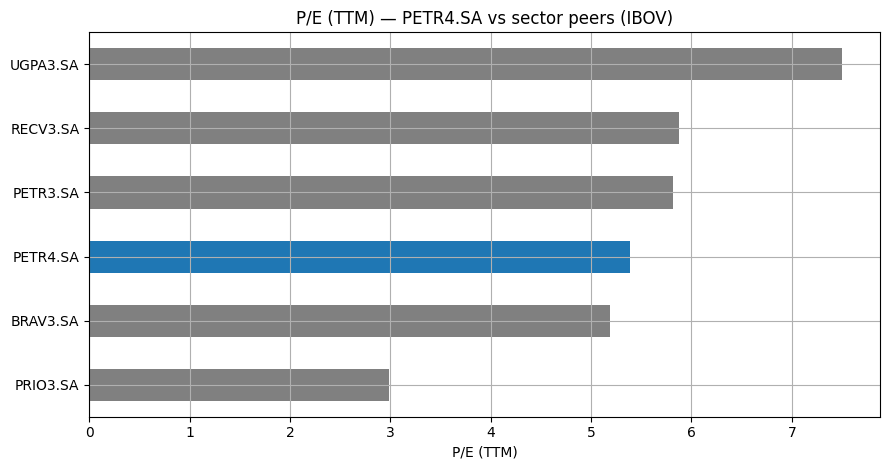

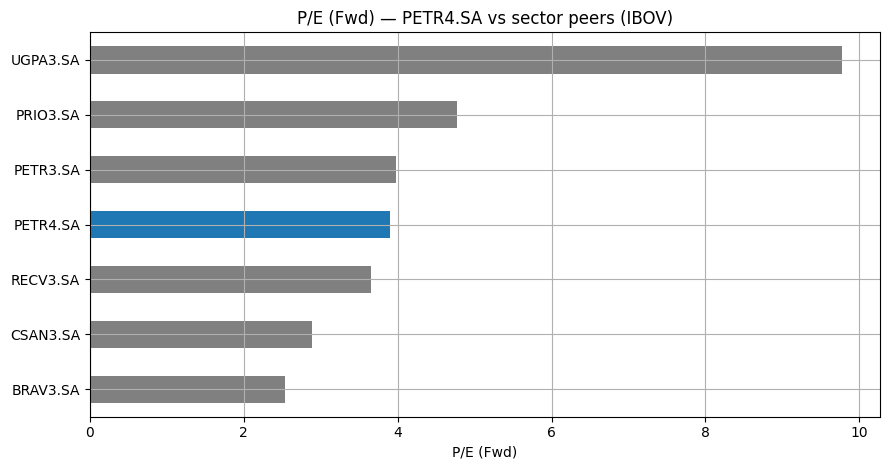

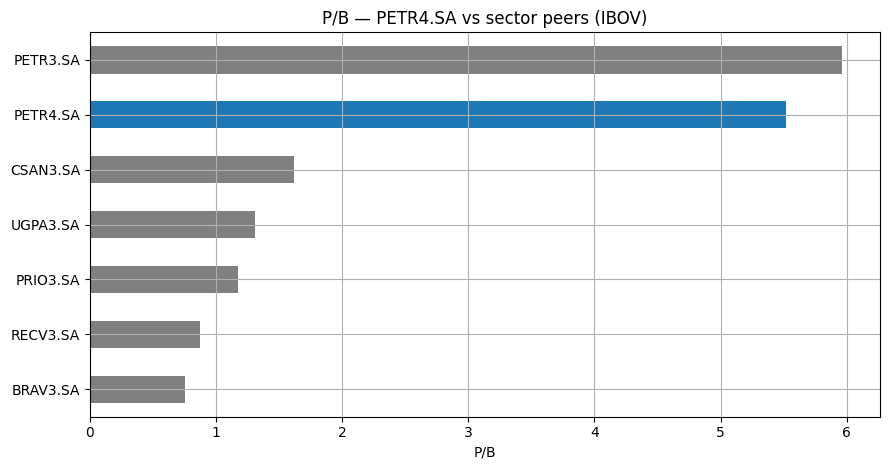

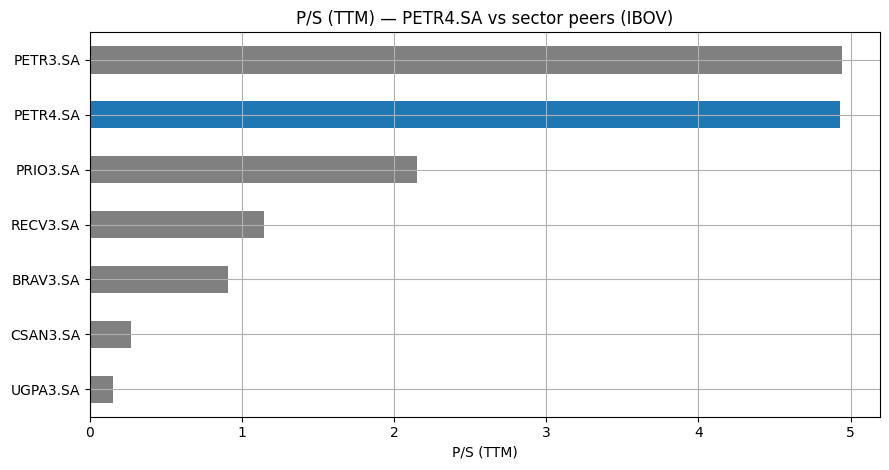

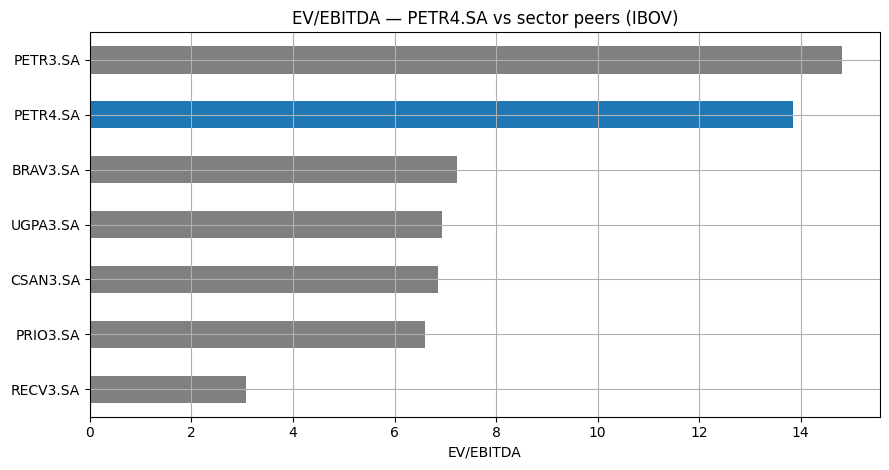

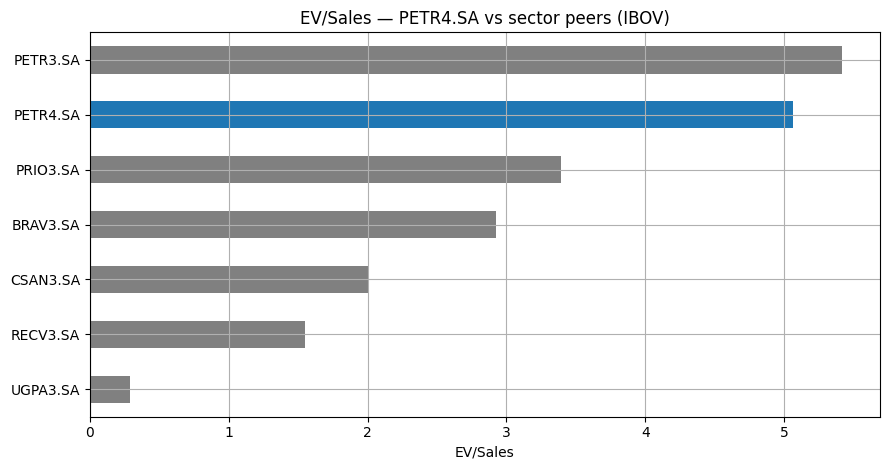

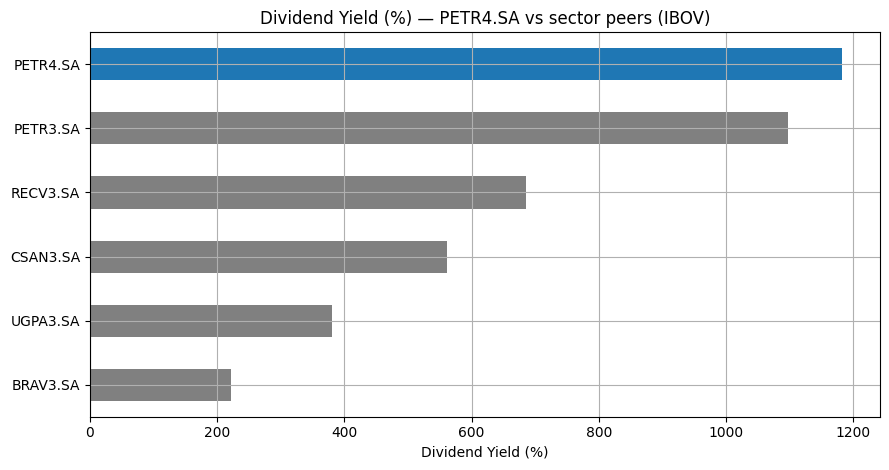

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import display

plt.rcParams["figure.figsize"] = (9, 4.8)
plt.rcParams["axes.grid"] = True

row = companies.loc[companies["ticker"] == ticker]
if row.empty:
    raise ValueError(f"Ticker {ticker} not found in companies list.")

company_index  = str(row["index"].iloc[0])
company_sector = row["sector"].iloc[0] if pd.notna(row["sector"].iloc[0]) else None

peers_df = companies[
    (companies["index"].str.upper() == company_index.upper()) &
    (companies["sector"] == company_sector) &
    (companies["ticker"] != ticker)
].copy()

peer_tickers = peers_df["ticker"].dropna().str.upper().unique().tolist()
peer_tickers = peer_tickers[:20]

if not peer_tickers:
    print("[info] No peers in same index+sector. Falling back to same index only.")
    peers_df = companies[
        (companies["index"].str.upper() == company_index.upper()) &
        (companies["ticker"] != ticker)
    ]
    peer_tickers = peers_df["ticker"].dropna().str.upper().unique().tolist()[:20]

print(f"Peer cohort → index: {company_index} | sector: {company_sector or 'N/A'} | peers: {len(peer_tickers)}")

def _to_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

def fetch_ratios_for(tkr: str) -> pd.Series:
    """
    Pull ratios from Yahoo; if EV/EBITDA or EV/Sales are missing,
    compute them from enterpriseValue, EBITDA, and Total Revenue.
    Uses most recent annual column available.
    """
    info = {}
    fin = pd.DataFrame()
    try:
        yt = yf.Ticker(tkr)
        info = yt.info
        fin = yt.financials if yt.financials is not None else pd.DataFrame()
    except Exception:
        pass

    pe_trailing  = _to_float(info.get("trailingPE"))
    pe_forward   = _to_float(info.get("forwardPE"))
    pb           = _to_float(info.get("priceToBook"))
    ps_ttm       = _to_float(info.get("priceToSalesTrailing12Months"))
    ev_to_ebitda = _to_float(info.get("enterpriseToEbitda"))
    div_yield    = _to_float(info.get("dividendYield")) * 100.0

    ev = _to_float(info.get("enterpriseValue"))
    ebitda_val, sales_val = np.nan, np.nan

    if fin is not None and not fin.empty:
        col0 = fin.columns[0]
        if "EBITDA" in fin.index:
            ebitda_val = _to_float(fin.loc["EBITDA", col0])
            if np.isnan(ebitda_val) and fin.shape[1] > 1:
                ebitda_val = _to_float(fin.loc["EBITDA", fin.columns[1]])
        if "Total Revenue" in fin.index:
            sales_val = _to_float(fin.loc["Total Revenue", col0])
            if np.isnan(sales_val) and fin.shape[1] > 1:
                sales_val = _to_float(fin.loc["Total Revenue", fin.columns[1]])

    if (np.isnan(ev_to_ebitda)) and (not np.isnan(ev)) and (not np.isnan(ebitda_val)) and (ebitda_val > 0):
        ev_to_ebitda = ev / ebitda_val

    ev_to_sales = np.nan
    if (not np.isnan(ev)) and (not np.isnan(sales_val)) and (sales_val > 0):
        ev_to_sales = ev / sales_val

    return pd.Series({
        "P/E (TTM)": pe_trailing,
        "P/E (Fwd)": pe_forward,
        "P/B": pb,
        "P/S (TTM)": ps_ttm,
        "EV/EBITDA": ev_to_ebitda,
        "EV/Sales": ev_to_sales,
        "Dividend Yield (%)": div_yield
    }, name=tkr)

tickers_to_pull = [ticker] + peer_tickers
results = {}

with ThreadPoolExecutor(max_workers=8) as ex:
    futures = {ex.submit(fetch_ratios_for, t): t for t in tickers_to_pull}
    for fut in as_completed(futures):
        t = futures[fut]
        try:
            results[t] = fut.result()
        except Exception as e:
            results[t] = pd.Series(name=t)
            print(f"[warn] Ratios failed for {t}: {e}")

ratios = pd.DataFrame(results).T
for c in ratios.columns:
    ratios[c] = pd.to_numeric(ratios[c], errors="coerce")

ratios = ratios.loc[:, ratios.notna().any(axis=0)]

peer_only = ratios.drop(index=ticker, errors="ignore")
if not peer_only.empty:
    q = peer_only.quantile([0.25, 0.5, 0.75])
    q.index = ["Q1 (25%)", "Median", "Q3 (75%)"]
    company_row = ratios.loc[[ticker]]
    comparison = pd.concat([company_row, q], axis=0)
else:
    comparison = ratios.loc[[ticker]]

fmt_map = {col: "{:.2f}" for col in comparison.columns}
display(
    comparison.style
              .format(fmt_map, na_rep="—")
              .set_caption(f"Valuation Ratios — {ticker} vs peers (index: {company_index}, sector: {company_sector or 'N/A'})")
)

if not peer_only.empty:
    def pct_in_peers(metric: str):
        if metric not in peer_only.columns: return np.nan
        vals = peer_only[metric].dropna().values
        if len(vals) == 0 or pd.isna(ratios.loc[ticker, metric]): return np.nan
        return (vals <= ratios.loc[ticker, metric]).mean()

    perc = {m: pct_in_peers(m) for m in peer_only.columns}
    perc_df = pd.DataFrame(perc, index=["Company percentile vs peers"]).T
    display(perc_df.style.format("{:.0%}"))

def plot_metric(df: pd.DataFrame, metric: str, main: str):
    if metric not in df.columns:
        print(f"[info] Skipping {metric} (missing)."); return
    s = df[metric].dropna().sort_values()
    if s.empty:
        print(f"[info] Skipping {metric} (no data)."); return
    colors = ["#1f77b4" if ix == main else "gray" for ix in s.index]
    ax = s.plot(kind="barh", color=colors)
    ax.set_title(f"{metric} — {main} vs sector peers ({company_index})")
    ax.set_xlabel(metric)
    plt.tight_layout(); plt.show()

for m in ["P/E (TTM)", "P/E (Fwd)", "P/B", "P/S (TTM)", "EV/EBITDA", "EV/Sales", "Dividend Yield (%)"]:
    plot_metric(ratios, m, ticker)

Income Statement (last 4 FY)


,Revenue,Cost of Revenue,Gross Profit,Operating Income,EBITDA,Net Income
2021,"83,966,000,000","43,164,000,000","40,802,000,000","31,001,000,000","44,897,000,000","19,875,000,000"
2022,"124,474,000,000","59,486,000,000","64,988,000,000","53,265,000,000","69,933,000,000","36,623,000,000"
2023,"102,409,000,000","48,435,000,000","53,974,000,000","39,473,000,000","52,292,000,000","24,884,000,000"
2024,"91,416,000,000","45,444,000,000","45,972,000,000","25,691,000,000","27,462,000,000","7,528,000,000"



Balance Sheet (last 4 FY)


,Total Assets,Total Liabilities,Equity,Cash & ST Inv.,Total Debt,Current Assets,Current Liabilities,Inventory,Net PPE
2021,"174,348,000,000","104,536,000,000","69,407,000,000","11,117,000,000","58,743,000,000","30,149,000,000","24,176,000,000","7,255,000,000","125,330,000,000"
2022,"187,191,000,000","117,355,000,000","69,492,000,000","10,769,000,000","53,799,000,000","31,250,000,000","31,380,000,000","8,779,000,000","130,169,000,000"
2023,"217,067,000,000","138,092,000,000","78,583,000,000","15,546,000,000","62,600,000,000","32,445,000,000","33,860,000,000","7,681,000,000","153,424,000,000"
2024,"181,645,000,000","122,295,000,000","59,106,000,000","7,534,000,000","60,311,000,000","21,836,000,000","31,460,000,000","6,710,000,000","136,285,000,000"



Cash Flow Statement (last 4 FY)


,CFO,CAPEX,FCF
2021,"37,791,000,000","6,325,000,000","31,466,000,000"
2022,"49,717,000,000","9,581,000,000","40,136,000,000"
2023,"43,212,000,000","12,114,000,000","31,098,000,000"
2024,"37,984,000,000","14,644,000,000","23,340,000,000"



Common-Size — Income Statement (as % of Revenue)


,Revenue,Cost of Revenue,Gross Profit,Operating Income,EBITDA,Net Income
2021,100.0%,51.4%,48.6%,36.9%,53.5%,23.7%
2022,100.0%,47.8%,52.2%,42.8%,56.2%,29.4%
2023,100.0%,47.3%,52.7%,38.5%,51.1%,24.3%
2024,100.0%,49.7%,50.3%,28.1%,30.0%,8.2%



Common-Size — Balance Sheet (as % of Total Assets)


,Total Assets,Total Liabilities,Equity,Cash & ST Inv.,Total Debt,Net PPE
2021,100.0%,60.0%,39.8%,6.4%,33.7%,71.9%
2022,100.0%,62.7%,37.1%,5.8%,28.7%,69.5%
2023,100.0%,63.6%,36.2%,7.2%,28.8%,70.7%
2024,100.0%,67.3%,32.5%,4.1%,33.2%,75.0%



Key Ratios — latest year available


,Latest
Gross Margin,0.50
EBITDA Margin,0.30
Operating Margin,0.28
Net Margin,0.08
Current Ratio,0.69
Quick Ratio,0.48
Debt / Equity,1.02
Debt / Assets,0.67
Net Debt / EBITDA,1.92


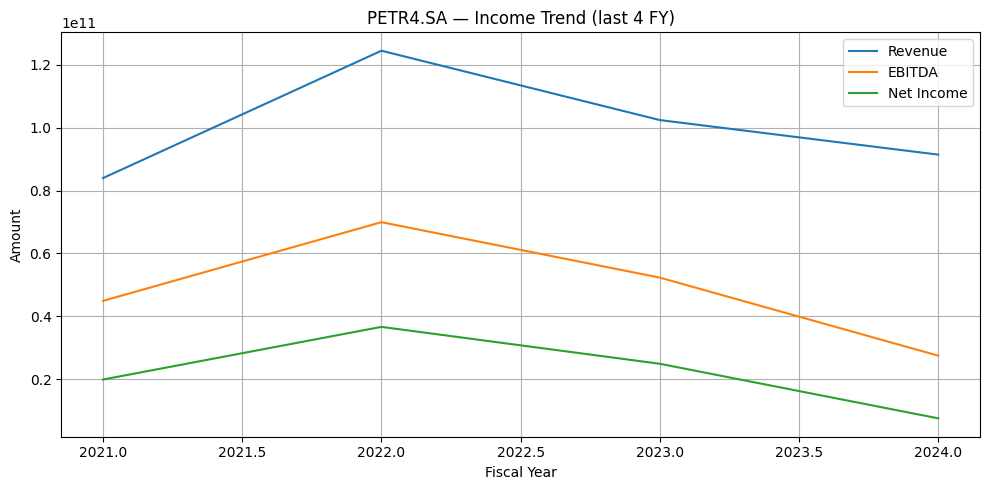

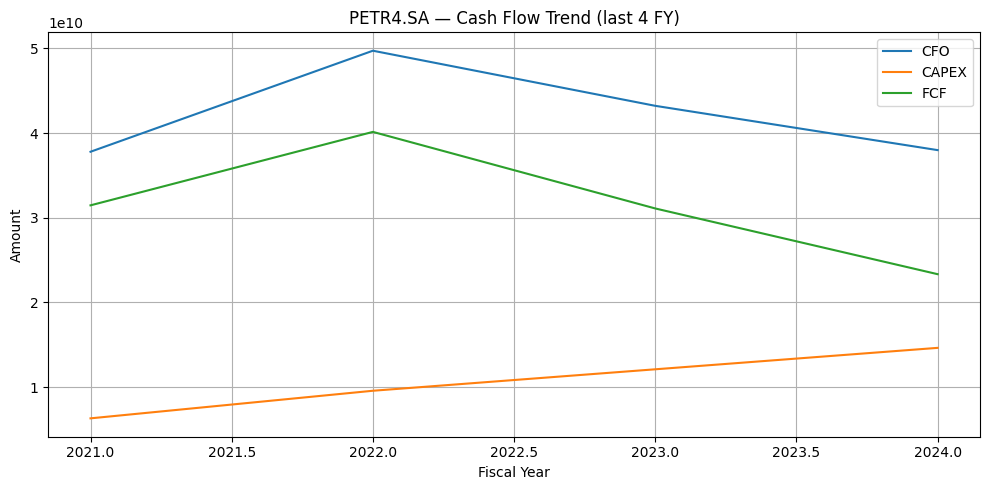


Note: Columns with <50% coverage are hidden; ‘—’ marks undisclosed fields. Safe fallbacks used where possible (EBIT ≈ EBITDA − D&A; Total Debt = short + long; current buckets via totals).


In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from IPython.display import display

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

MIN_COVERAGE = 0.50

yt = yf.Ticker(ticker)

def _prep(df, take_last=4):
    if df is None or (isinstance(df, pd.DataFrame) and df.empty):
        return pd.DataFrame()
    out = df.T.copy()
    try: out.index = pd.to_datetime(out.index).year
    except: pass
    out = out.sort_index().tail(take_last)
    for c in out.columns: out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

fin_raw = _prep(yt.financials)
bs_raw  = _prep(yt.balance_sheet)
cf_raw  = _prep(yt.cashflow)
if fin_raw.empty and bs_raw.empty and cf_raw.empty:
    raise RuntimeError(f"No financial statements available for {ticker}.")

def pick(df, label_opts):
    if df.empty: return pd.Series(dtype=float)
    for lab in label_opts:
        if lab in df.columns:
            return pd.to_numeric(df[lab], errors="coerce")
    return pd.Series([np.nan]*len(df), index=df.index, dtype=float)

def prune_sparse(df, min_cov=MIN_COVERAGE):
    if df.empty: return df
    keep = [c for c in df.columns if df[c].notna().mean() >= min_cov]
    return df[keep]

revenue      = pick(fin_raw, ["Total Revenue","Revenue"])
cost_rev     = pick(fin_raw, ["Cost Of Revenue","Cost of Revenue"])
gross_profit = pick(fin_raw, ["Gross Profit"])
oper_income  = pick(fin_raw, ["Operating Income","OperatingIncome","EBIT"])
ebitda       = pick(fin_raw, ["EBITDA"])
dep_amort    = pick(fin_raw, ["Reconciled Depreciation","Depreciation & Amortization","Depreciation"])
net_income   = pick(fin_raw, ["Net Income","NetIncome"])

if gross_profit.notna().sum()==0 and (revenue.notna().sum()>0 and cost_rev.notna().sum()>0):
    gross_profit = revenue - cost_rev
if oper_income.notna().sum()==0 and (ebitda.notna().sum()>0 and dep_amort.notna().sum()>0):
    oper_income = ebitda - dep_amort
if ebitda.notna().sum()==0 and (oper_income.notna().sum()>0 and dep_amort.notna().sum()>0):
    ebitda = oper_income + dep_amort

income_tbl = pd.DataFrame({
    "Revenue": revenue,
    "Cost of Revenue": cost_rev,
    "Gross Profit": gross_profit,
    "Operating Income": oper_income,
    "EBITDA": ebitda,
    "Net Income": net_income,
}).round(0)
income_tbl = prune_sparse(income_tbl)

tot_assets = pick(bs_raw, ["Total Assets"])
tot_liab   = pick(bs_raw, ["Total Liabilities Net Minority Interest","Total Liabilities"])
equity     = pick(bs_raw, ["Total Stockholder Equity","Stockholders Equity"])
cash_sti   = pick(bs_raw, ["Cash Cash Equivalents And Short Term Investments","Cash And Cash Equivalents"])
short_debt = pick(bs_raw, ["Short Long Term Debt"])
long_debt  = pick(bs_raw, ["Long Term Debt","Long Term Debt And Capital Lease Obligation"])
tot_debt   = pick(bs_raw, ["Total Debt"])
if tot_debt.notna().sum()==0:
    tot_debt = short_debt.add(long_debt, fill_value=0.0)

cur_assets = pick(bs_raw, ["Total Current Assets","Current Assets"])
cur_liab   = pick(bs_raw, ["Total Current Liabilities","Current Liabilities"])
invent     = pick(bs_raw, ["Inventory","Inventories Net"]).fillna(0)
net_ppe    = pick(bs_raw, ["Net PPE","Property Plant Equipment Net","Property Plant & Equipment Net"])

noncur_assets = pick(bs_raw, ["Total Non Current Assets","Total Assets Non Current"])
noncur_liab   = pick(bs_raw, ["Total Non Current Liabilities Net Minority Interest","Total Liabilities Non Current"])
if cur_assets.notna().sum()==0 and tot_assets.notna().sum()>0 and noncur_assets.notna().sum()>0:
    cur_assets = tot_assets - noncur_assets
if cur_liab.notna().sum()==0 and tot_liab.notna().sum()>0 and noncur_liab.notna().sum()>0:
    cur_liab = tot_liab - noncur_liab

balance_tbl = pd.DataFrame({
    "Total Assets": tot_assets,
    "Total Liabilities": tot_liab,
    "Equity": equity,
    "Cash & ST Inv.": cash_sti,
    "Total Debt": tot_debt,
    "Current Assets": cur_assets,
    "Current Liabilities": cur_liab,
    "Inventory": invent,
    "Net PPE": net_ppe,
}).round(0)
balance_tbl = prune_sparse(balance_tbl)

cfo   = pick(cf_raw, ["Operating Cash Flow","Total Cash From Operating Activities"])
capex = -pick(cf_raw, ["Capital Expenditure","Investments"]).fillna(0)
fcf   = pick(cf_raw, ["Free Cash Flow"])
if fcf.notna().sum()==0 and (cfo.notna().sum()>0):
    fcf = (cfo - capex).rename("Free Cash Flow (derived)")

cashflow_tbl = pd.DataFrame({"CFO": cfo, "CAPEX": capex, "FCF": fcf}).round(0)
cashflow_tbl = prune_sparse(cashflow_tbl)

def _pct(numer, denom):
    if numer.empty or denom.empty: return pd.Series(dtype=float)
    return (numer/denom).replace([np.inf,-np.inf], np.nan)

income_cs = pd.DataFrame(index=income_tbl.index)
if "Revenue" in income_tbl:
    income_cs["Revenue"] = 1.0
    for col in [c for c in ["Cost of Revenue","Gross Profit","Operating Income","EBITDA","Net Income"] if c in income_tbl]:
        income_cs[col] = _pct(income_tbl[col], income_tbl["Revenue"])

balance_cs = pd.DataFrame(index=balance_tbl.index)
if "Total Assets" in balance_tbl:
    balance_cs["Total Assets"] = 1.0
    for col in [c for c in ["Total Liabilities","Equity","Cash & ST Inv.","Total Debt","Net PPE"] if c in balance_tbl]:
        balance_cs[col] = _pct(balance_tbl[col], balance_tbl["Total Assets"])

def last_valid(series):
    if series is None:
        return np.nan
    try:
        s = pd.to_numeric(pd.Series(series), errors="coerce").dropna()
        return float(s.iloc[-1]) if not s.empty else np.nan
    except Exception:
        return np.nan

rev = income_tbl.get("Revenue"); ni = income_tbl.get("Net Income")
gp  = income_tbl.get("Gross Profit"); op = income_tbl.get("Operating Income"); eb = income_tbl.get("EBITDA")

gross_margin  = (gp/rev)   if (gp is not None and rev is not None) else pd.Series(dtype=float)
ebitda_margin = (eb/rev)   if (eb is not None and rev is not None) else pd.Series(dtype=float)
oper_margin   = (op/rev)   if (op is not None and rev is not None) else pd.Series(dtype=float)
net_margin    = (ni/rev)   if (ni is not None and rev is not None) else pd.Series(dtype=float)

td = balance_tbl.get("Total Debt"); csh = balance_tbl.get("Cash & ST Inv.")
eq = balance_tbl.get("Equity"); ta = balance_tbl.get("Total Assets")
ca = balance_tbl.get("Current Assets"); cl = balance_tbl.get("Current Liabilities"); inv = balance_tbl.get("Inventory")

net_debt      = (td.sub(csh, fill_value=0.0)) if (td is not None and csh is not None) else pd.Series(dtype=float)
current_ratio = (ca/cl) if (ca is not None and cl is not None) else pd.Series(dtype=float)
quick_ratio   = ((ca.sub(inv, fill_value=0.0))/cl) if (ca is not None and cl is not None and inv is not None) else pd.Series(dtype=float)
debt_to_equity= (td/eq) if (td is not None and eq is not None) else pd.Series(dtype=float)
debt_to_assets= (balance_tbl.get("Total Liabilities")/ta) if (ta is not None and balance_tbl.get("Total Liabilities") is not None) else pd.Series(dtype=float)

eb_last  = last_valid(eb)
nd_last  = last_valid(net_debt)
nd_over_ebitda = (nd_last/eb_last) if (np.isfinite(eb_last) and eb_last>0) else np.nan

ratios_snapshot = pd.Series({
    "Gross Margin": last_valid(gross_margin),
    "EBITDA Margin": last_valid(ebitda_margin),
    "Operating Margin": last_valid(oper_margin),
    "Net Margin": last_valid(net_margin),
    "Current Ratio": last_valid(current_ratio),
    "Quick Ratio": last_valid(quick_ratio),
    "Debt / Equity": last_valid(debt_to_equity),
    "Debt / Assets": last_valid(debt_to_assets),
    "Net Debt / EBITDA": nd_over_ebitda,
}).to_frame("Latest")

def fmt_money(df): return df.style.format("{:,.0f}", na_rep="—")
def fmt_pct(df):   return df.style.format("{:.1%}", na_rep="—")

print("Income Statement (last 4 FY)"); display(fmt_money(income_tbl))
print("\nBalance Sheet (last 4 FY)");   display(fmt_money(balance_tbl))
print("\nCash Flow Statement (last 4 FY)"); display(fmt_money(cashflow_tbl))

if not income_cs.empty:
    print("\nCommon-Size — Income Statement (as % of Revenue)")
    cols_inc = [c for c in ["Revenue","Cost of Revenue","Gross Profit","Operating Income","EBITDA","Net Income"] if c in income_cs]
    display(fmt_pct(income_cs[cols_inc]))

if not balance_cs.empty:
    print("\nCommon-Size — Balance Sheet (as % of Total Assets)")
    cols_bal = [c for c in ["Total Assets","Total Liabilities","Equity","Cash & ST Inv.","Total Debt","Net PPE"] if c in balance_cs]
    display(fmt_pct(balance_cs[cols_bal]))

print("\nKey Ratios — latest year available")
display(ratios_snapshot.style.format({"Latest":"{:,.2f}"}, na_rep="—"))

fig, ax = plt.subplots()
for col in [c for c in ["Revenue","EBITDA","Net Income"] if c in income_tbl]:
    ax.plot(income_tbl.index, income_tbl[col].values, label=col)
ax.set_title(f"{ticker} — Income Trend (last 4 FY)"); ax.set_xlabel("Fiscal Year"); ax.set_ylabel("Amount"); ax.legend()
plt.tight_layout(); plt.show()

fig, ax = plt.subplots()
for col in [c for c in ["CFO","CAPEX","FCF"] if c in cashflow_tbl]:
    ax.plot(cashflow_tbl.index, cashflow_tbl[col].values, label=col)
ax.set_title(f"{ticker} — Cash Flow Trend (last 4 FY)"); ax.set_xlabel("Fiscal Year"); ax.set_ylabel("Amount"); ax.legend()
plt.tight_layout(); plt.show()

print("\nNote: Columns with <50% coverage are hidden; ‘—’ marks undisclosed fields. "
      "Safe fallbacks used where possible (EBIT ≈ EBITDA − D&A; Total Debt = short + long; current buckets via totals).")

# 5. Valuation Setup: Macro-Consistent WACC & Terminal Growth

A valuation only makes sense when its economics rhyme with the world outside the spreadsheet. Discount rates live in a currency and a price level; long-run growth is capped by an economy’s capacity; country risk and size effects matter more than slide decks admit.  

In this step, we translate macro signals into model inputs. We start with a clean **Cost of Equity in USD**, then convert it to the company’s **home currency** via inflation parity. We triangulate the **Cost of Debt** from the firm’s statements (or anchor it to local rates when needed), blend both through the capital structure to obtain **WACC**, and set a **terminal growth** that respects economic gravity—nominal, country-consistent, and safely below WACC.  

From here on, cash-flow models won’t float: they’ll be moored to the macro currents the business actually swims in.

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf

row = companies.loc[companies["ticker"] == ticker]
if row.empty:
    raise ValueError(f"Ticker {ticker} not found in companies list.")
row = row.iloc[0]

company_index = str(row["index"]).upper()
COUNTRY = {"SP500": "USA", "IPC": "MEXICO", "IBOVESPA": "BRAZIL", "IBOV": "BRAZIL"}.get(company_index, "USA")

def _from_macro(table, key, default):
    try:
        vals = pd.to_numeric(table.loc[key, :], errors="coerce")
        return float(vals.mean())
    except Exception:
        return float(default)

macro_available = "tabela_macro" in globals()

if macro_available:
    CPI_USA = _from_macro(tabela_macro, "CPI", 3.0) / 100.0
    IPCA_BR = _from_macro(tabela_macro, "IPCA", 4.0) / 100.0
    CPI_MX  = _from_macro(tabela_macro, "INPC_MX", 4.0) / 100.0

    GDP_REAL_BR = _from_macro(tabela_macro, "PIB Total", 2.0) / 100.0
    GDP_REAL_US = _from_macro(tabela_macro, "GDP_REAL_US", 1.8) / 100.0
    GDP_REAL_MX = _from_macro(tabela_macro, "GDP_REAL_MX", 2.0) / 100.0
else:
    CPI_USA, CPI_MX, IPCA_BR = 0.025, 0.040, 0.040
    GDP_REAL_US, GDP_REAL_MX, GDP_REAL_BR = 0.018, 0.020, 0.020

if COUNTRY == "USA":
    infl_local, g_real = CPI_USA, GDP_REAL_US
elif COUNTRY == "MEXICO":
    infl_local, g_real = CPI_MX, GDP_REAL_MX
else:
    infl_local, g_real = IPCA_BR, GDP_REAL_BR

infl_usd = CPI_USA

try:
    import pandas_datareader.data as web
    end = pd.Timestamp.today().normalize()
    start = end - pd.Timedelta(days=365)
    rf_series = web.DataReader("DGS10", "fred", start, end).dropna()
    RF_USD = float(rf_series.iloc[-1, 0]) / 100.0
except Exception:
    RF_USD = 0.042

ERP_USD = 0.050

CRP = {"USA": 0.000, "MEXICO": 0.015, "BRAZIL": 0.025}.get(COUNTRY, 0.000)

yt = yf.Ticker(ticker)
info, fin, bs = {}, pd.DataFrame(), pd.DataFrame()
try:
    info = yt.info
    fin = yt.financials if yt.financials is not None else pd.DataFrame()
    bs  = yt.balance_sheet if yt.balance_sheet is not None else pd.DataFrame()
except Exception:
    pass

beta = info.get("beta", np.nan)
beta = float(beta) if beta is not None else np.nan
if np.isnan(beta):
    beta = 1.00

def size_premium_bps(market_cap):
    """Return decimal (e.g., 0.01 = 1%) using simple market-cap buckets."""
    thresholds = [50e9, 25e9, 12.5e9, 6.25e9, 3.125e9, 1.5625e9, 781.25e6, 390.625e6, 195.3125e6]
    sp = 0.0
    mc = market_cap or 0.0
    for th in thresholds:
        if mc < th:
            sp += 0.01
    return min(sp, 0.10)

mktcap = info.get("marketCap", np.nan) or np.nan
SZ = size_premium_bps(mktcap)

def _pick_across_cols(df, label_opts):
    """From a yfinance statements DF (rows=labels, cols=periods), pick the latest non-NaN for any of the given labels."""
    if df is None or df.empty:
        return np.nan
    for lab in label_opts:
        if lab in df.index:
            s = pd.to_numeric(df.loc[lab], errors="coerce")
            s = s.dropna()
            if not s.empty:
                return float(s.iloc[0])
    return np.nan

tax_rate = info.get("effectiveTaxRate", np.nan)
if (tax_rate is None) or np.isnan(tax_rate):
    tax_rate = _pick_across_cols(fin, ["Tax Rate For Calcs"])
if (tax_rate is None) or np.isnan(tax_rate):
    tax_rate = 0.25

total_debt = _pick_across_cols(bs, ["Total Debt", "Short Long Term Debt", "Long Term Debt"])
cash_sti   = _pick_across_cols(bs, ["Cash Cash Equivalents And Short Term Investments", "Cash And Cash Equivalents"])
if np.isnan(total_debt): total_debt = 0.0
if np.isnan(cash_sti):   cash_sti   = 0.0

net_debt   = max(total_debt - cash_sti, 0.0)
equity_val = float(mktcap) if not np.isnan(mktcap) else 0.0
capital    = equity_val + net_debt if (equity_val + net_debt) > 0 else 1.0
w_e        = equity_val / capital
w_d        = net_debt   / capital

KE_USD = RF_USD + beta * (ERP_USD + CRP) + SZ
KE_LOCAL = (1.0 + KE_USD) * (1.0 + infl_local) / (1.0 + infl_usd) - 1.0

interest_exp = _pick_across_cols(fin, ["Interest Expense"])
if (not np.isnan(interest_exp)) and (total_debt > 0):
    KD_eff = max(abs(interest_exp) / total_debt, 0.0)
else:
    RF_LOCAL = (1.0 + RF_USD) * (1.0 + infl_local) / (1.0 + infl_usd) - 1.0
    KD_eff   = RF_LOCAL + 0.02

KD_AFTER_TAX = KD_eff * (1.0 - tax_rate)

WACC = w_e * KE_LOCAL + w_d * KD_AFTER_TAX

g_nominal = infl_local + g_real
g_nominal = float(min(g_nominal, max(WACC - 0.01, 0.0)))

out = pd.Series({
    "Country": COUNTRY,
    "Inflation (local, %)": infl_local * 100.0,
    "Inflation (USD, %)":   infl_usd * 100.0,
    "Real GDP anchor (%, long-run)": g_real * 100.0,
    "RF (USD, %)":          RF_USD * 100.0,
    "ERP (USD, %)":         ERP_USD * 100.0,
    "Country RP add (%, USD)": CRP * 100.0,
    "Beta": beta,
    "Size premium (%, USD)": SZ * 100.0,
    "KE (USD, %)":          KE_USD * 100.0,
    "KE (Local, %)":        KE_LOCAL * 100.0,
    "KD (pre-tax, Local, %)": KD_eff * 100.0,
    "Tax rate (%)":         tax_rate * 100.0,
    "KD (after-tax, Local, %)": KD_AFTER_TAX * 100.0,
    "Weight Equity (wE)":   w_e,
    "Weight Debt (wD)":     w_d,
    "WACC (Local, %)":      WACC * 100.0,
    "Terminal g (Local, %, guarded)": g_nominal * 100.0
}, name=f"WACC & g — {ticker}")

df_out = out.to_frame("Value")

def _fmt_value(v):
    try:
        if isinstance(v, (int, float, np.floating)) and pd.notna(v):
            return f"{v:.2f}"
        return v if v is not None else "—"
    except Exception:
        return v

display(df_out.style.format({"Value": _fmt_value}))

,Value
Country,BRAZIL
"Inflation (local, %)",4.00
"Inflation (USD, %)",2.50
"Real GDP anchor (%, long-run)",2.00
"RF (USD, %)",4.23
"ERP (USD, %)",5.00
"Country RP add (%, USD)",2.50
Beta,0.32
"Size premium (%, USD)",0.00
"KE (USD, %)",6.62


# 6. Intrinsic Valuation (DCF — FCFF)

Valuation is a promise about cash, not just stories about multiples. Here we estimate the firm’s **free cash flow to the firm (FCFF)**, project it over five years, and discount those flows at a **macro-consistent WACC** (from the previous step). We let history set the guardrails—revenue growth fades toward long-run nominal growth, margins migrate toward recent norms, **CAPEX** and **working capital** follow their historical intensities—and we keep the math currency-consistent.

At the end of the forecast we compute a **terminal value** using a conservative, country-aware nominal growth rate \(g\) that stays below WACC. Subtracting **net debt** converts enterprise value into **equity value**, and dividing by shares yields an **implied fair price**. A small sensitivity matrix around WACC and \(g\) shows how fragile—or robust—the conclusion is.

In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
from IPython.display import display

def _to_num(x, default=np.nan):
    try:
        v = float(x)
        return v if np.isfinite(v) else default
    except Exception:
        return default

def safe_mean(s, win=None):
    s = pd.Series(s, dtype="float64").dropna()
    if win:
        s = s.tail(win)
    return s.mean() if not s.empty else np.nan

def clamp(x, lo, hi):
    try:
        return float(np.clip(x, lo, hi))
    except Exception:
        return x

def with_default(val, default):
    return default if (val is None or not np.isfinite(val)) else float(val)

if "WACC" not in globals() or not np.isfinite(_to_num(globals().get("WACC"))):
    WACC = 0.10
if "g_nominal" not in globals() or not np.isfinite(_to_num(globals().get("g_nominal"))):
    g_nominal = 0.03

yt = yf.Ticker(ticker)

def prep(df, take_last=6):
    if df is None or (isinstance(df, pd.DataFrame) and df.empty):
        return pd.DataFrame()
    out = df.T.copy()
    try:
        out.index = pd.to_datetime(out.index).year
    except Exception:
        pass
    out = out.sort_index().tail(take_last)
    for c in out.columns:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

fin = prep(yt.financials, take_last=6)
bs  = prep(yt.balance_sheet, take_last=6)
cf  = prep(yt.cashflow, take_last=6)

if fin.empty or bs.empty:
    raise RuntimeError(f"Insufficient financial data for {ticker} to run DCF.")

def pick(df, labels, default=np.nan):
    if df.empty:
        return pd.Series([default]*0, dtype=float)
    for lab in labels:
        if lab in df.columns:
            return pd.to_numeric(df[lab], errors="coerce")
    return pd.Series([default]*len(df), index=df.index, dtype=float)

revenue      = pick(fin, ["Total Revenue", "Revenue"])
ebit         = pick(fin, ["Operating Income", "EBIT", "OperatingIncome"])
ebitda       = pick(fin, ["EBITDA"])
dep_amort    = pick(fin, ["Reconciled Depreciation", "Depreciation & Amortization", "Depreciation"])

if ebit.isna().all() and not ebitda.isna().all() and not dep_amort.isna().all():
    ebit = (ebitda - dep_amort).rename("EBIT (derived)")

curr_assets  = pick(bs, ["Total Current Assets"])
curr_liab    = pick(bs, ["Total Current Liabilities"])
cash_sti     = pick(bs, ["Cash Cash Equivalents And Short Term Investments", "Cash And Cash Equivalents"]).fillna(0)
total_debt   = pick(bs, ["Total Debt", "Short Long Term Debt", "Long Term Debt"]).fillna(0)

cfo          = pick(cf, ["Operating Cash Flow", "Total Cash From Operating Activities"])
capex_raw    = pick(cf, ["Capital Expenditure", "Investments"])
capex_hst    = -capex_raw

nwc = (curr_assets - cash_sti) - curr_liab

DEFAULTS = {
    "ebit_margin": 0.15,
    "da_to_rev":   0.04,
    "capex_to_rev":0.06,
    "nwc_to_rev":  0.05
}
win = 3

rev_hist = revenue.dropna()
if len(rev_hist) >= 2:
    years = max(rev_hist.index[-1] - rev_hist.index[0], len(rev_hist)-1)
    g_hist = (rev_hist.iloc[-1] / rev_hist.iloc[0]) ** (1/years) - 1
else:
    g_hist = np.nan
g0 = with_default(clamp(g_hist, -0.10, 0.20), g_nominal + 0.03)
growth_path = np.linspace(g0, g_nominal, 5)

ebit_margin = with_default(clamp(safe_mean((ebit/revenue), win=win), -0.10, 0.35), DEFAULTS["ebit_margin"])
da_to_rev   = with_default(clamp(safe_mean((dep_amort/revenue).replace([np.inf,-np.inf], np.nan), win=win), 0.00, 0.08), DEFAULTS["da_to_rev"])
capex_to_rev= with_default(clamp(safe_mean((capex_hst/revenue).replace([np.inf,-np.inf], np.nan), win=win), 0.02, 0.15), DEFAULTS["capex_to_rev"])
nwc_to_rev  = with_default(clamp(safe_mean((nwc/revenue).replace([np.inf,-np.inf], np.nan), win=win), -0.10, 0.35), DEFAULTS["nwc_to_rev"])

tax_rate = globals().get("tax_rate", np.nan)
if not np.isfinite(_to_num(tax_rate)):
    pretax = pick(fin, ["Pretax Income", "Income Before Tax"])
    taxexp = pick(fin, ["Tax Provision", "Income Tax Expense", "Tax Expense"])
    eff_hist = (taxexp.abs() / pretax.abs()).replace([np.inf,-np.inf], np.nan)
    tax_rate = with_default(clamp(safe_mean(eff_hist, win=win), 0.15, 0.35), 0.25)
else:
    tax_rate = clamp(tax_rate, 0.10, 0.40)

rev0 = revenue.dropna().iloc[-1] if not revenue.dropna().empty else np.nan
if not np.isfinite(rev0):
    raise RuntimeError("Cannot start DCF: last revenue is missing.")
nwc_prev = with_default(nwc.dropna().iloc[-1] if not nwc.dropna().empty else rev0 * nwc_to_rev,
                        rev0 * DEFAULTS["nwc_to_rev"])

proj = []
rev_t = rev0
for i, gy in enumerate(growth_path, start=1):
    year   = f"Y{i}"
    rev_t  = rev_t * (1.0 + float(gy))
    ebit_t = rev_t * ebit_margin
    da_t   = rev_t * da_to_rev
    nopat_t = ebit_t * (1.0 - tax_rate)
    capex_t = rev_t * capex_to_rev
    nwc_t   = rev_t * nwc_to_rev
    d_nwc_t = nwc_t - nwc_prev
    if not np.isfinite(_to_num(d_nwc_t)):
        d_nwc_t = 0.0
    nwc_prev = with_default(nwc_t, nwc_prev)

    fcff_t = nopat_t + da_t - capex_t - d_nwc_t
    proj.append({"Year": year, "Revenue": rev_t, "EBIT Margin": ebit_margin,
                 "EBIT": ebit_t, "Tax Rate": tax_rate, "NOPAT": nopat_t,
                 "D&A": da_t, "CAPEX": capex_t, "ΔNWC": d_nwc_t, "FCFF": fcff_t})

proj_df = pd.DataFrame(proj).set_index("Year")

if not (WACC > g_nominal):
    g_nominal = max(min(g_nominal, WACC - 0.01), 0.0)

fcff_5 = proj_df["FCFF"].iloc[-1]
tv = fcff_5 * (1.0 + g_nominal) / (WACC - g_nominal)

yrs = [1,2,3,4,5]
disc = pd.Series([(1.0 / (1.0 + WACC) ** t) for t in yrs], index=proj_df.index, name="Discount Factor")
pv_fcff = proj_df["FCFF"] * disc
pv_tv   = tv * disc.iloc[-1]
ev = pv_fcff.sum() + pv_tv

total_debt_last = total_debt.dropna().iloc[-1] if not total_debt.dropna().empty else 0.0
cash_last       = cash_sti.dropna().iloc[-1]   if not cash_sti.dropna().empty else 0.0
net_debt = max(total_debt_last - cash_last, 0.0)

info = {}
try:
    info = yt.info
except Exception:
    pass
shares_out = _to_num(info.get("sharesOutstanding")) or _to_num(info.get("impliedSharesOutstanding"))
price_now  = np.nan
try:
    h = yt.history(period="1mo")
    if not h.empty: price_now = float(h["Close"].iloc[-1])
except Exception:
    pass

equity_value = ev - net_debt
implied_px   = (equity_value / shares_out) if (shares_out and shares_out > 0) else np.nan

fmt_cols_money = ["Revenue","EBIT","NOPAT","D&A","CAPEX","ΔNWC","FCFF"]
fmt_map_proj = {c: "{:,.0f}" for c in fmt_cols_money}
fmt_map_proj.update({"EBIT Margin": "{:.1%}", "Tax Rate": "{:.1%}"})

display(proj_df.style.format(fmt_map_proj))

display(pd.DataFrame({"Discount Factor": disc, "PV(FCFF)": pv_fcff})
        .style.format({"Discount Factor": "{:.4f}", "PV(FCFF)": "{:,.0f}"}))

summary = pd.Series({
    "WACC (%)": WACC * 100.0,
    "Terminal g (%)": g_nominal * 100.0,
    "Enterprise Value": ev,
    "Net Debt (>=0)": net_debt,
    "Equity Value": equity_value,
    "Shares Outstanding": shares_out,
    "Implied Price": implied_px,
    "Current Price": price_now
}, name=f"DCF Summary — {ticker}")

def _fmt(v):
    if isinstance(v, (int, float, np.floating)) and np.isfinite(v):
        return f"{v:,.2f}" if abs(v) < 1000 else f"{v:,.0f}"
    return v

display(summary.to_frame("Value").style.format({"Value": _fmt}))

buffer = 0.005

wacc_grid = np.array([WACC - 0.02, WACC, WACC + 0.02])
wacc_grid = np.sort(wacc_grid)

g_low  = max(g_nominal - 0.005, 0.0)
g_mid  = min(g_nominal, wacc_grid.min() - buffer)
g_high = min(g_nominal + 0.005, wacc_grid.min() - buffer/2)

g_candidates = [g for g in [g_low, g_mid, g_high] if g >= 0]
g_grid = np.array(sorted({round(g, 6) for g in g_candidates}))

def price_for(w, g):
    disc_local = pd.Series([(1.0 / (1.0 + w) ** t) for t in yrs], index=proj_df.index)
    tv_local = proj_df["FCFF"].iloc[-1] * (1.0 + g) / (w - g)
    pv_total = (proj_df["FCFF"] * disc_local).sum() + tv_local * disc_local.iloc[-1]
    eq = pv_total - net_debt
    return (eq / shares_out) if (shares_out and shares_out > 0) else np.nan

sens = pd.DataFrame(
    [[price_for(w, g) for w in wacc_grid] for g in g_grid],
    index=[f"g={g*100:.2f}%" for g in g_grid],
    columns=[f"WACC={w*100:.2f}%" for w in wacc_grid]
)

display(sens.style.format("{:,.2f}").set_caption("Implied Price Sensitivity (per share) — valid (WACC > g) only"))

diag = pd.Series({
    "EBIT margin used": ebit_margin,
    "D&A/Revenue used": da_to_rev,
    "CAPEX/Revenue used": capex_to_rev,
    "NWC/Revenue used": nwc_to_rev,
    "Tax rate used": tax_rate
}).to_frame("Value").style.format({"Value": "{:.2%}"})
print("\nDiagnostics — drivers used:")
display(diag)

,Revenue,EBIT Margin,EBIT,Tax Rate,NOPAT,D&A,CAPEX,ΔNWC,FCFF
Year,,,,,,,,,
Y1,"94,043,430,810",35.0%,"32,915,200,783",31.7%,"22,481,082,135","7,523,474,465","11,142,675,041","131,371,540","18,730,510,018"
Y2,"97,481,292,560",35.0%,"34,118,452,396",31.7%,"23,302,902,986","7,798,503,405","11,550,007,866","171,893,088","19,379,505,438"
Y3,"101,806,609,473",35.0%,"35,632,313,316",31.7%,"24,336,869,995","8,144,528,758","12,062,490,241","216,265,846","20,202,642,665"
Y4,"107,119,424,966",35.0%,"37,491,798,738",31.7%,"25,606,898,538","8,569,553,997","12,691,975,747","265,640,775","21,218,836,014"
Y5,"113,546,590,464",35.0%,"39,741,306,663",31.7%,"27,143,312,450","9,083,727,237","13,453,494,292","321,358,275","22,452,187,121"


,Discount Factor,PV(FCFF)
Year,,
Y1,0.9280,"17,382,219,071"
Y2,0.8612,"16,689,907,196"
Y3,0.7992,"16,146,374,839"
Y4,0.7417,"15,737,799,953"
Y5,0.6883,"15,453,851,449"


,Value
WACC (%),7.76
Terminal g (%),6.00
Enterprise Value,"1,013,888,582,948"
Net Debt (>=0),"52,777,000,000"
Equity Value,"961,111,582,948"
Shares Outstanding,"5,446,499,840"
Implied Price,176.46
Current Price,31.33


,WACC=5.76%,WACC=7.76%,WACC=9.76%
g=5.26%,662.04,124.72,65.01
g=5.50%,"1,286.63",137.90,68.62
g=5.51%,"1,321.02",138.31,68.73



Diagnostics — drivers used:


,Value
EBIT margin used,35.00%
D&A/Revenue used,8.00%
CAPEX/Revenue used,11.85%
NWC/Revenue used,5.00%
Tax rate used,31.70%


# 7. Market-Implied Valuation (Comparables Bridge)

Multiples are useful only when they connect to cash or shares. Here we translate the **peer cohort’s** median ratios into **implied enterprise/equity values** for our company and compare them with today’s price.  

We use three lenses—**EV/EBITDA**, **EV/Sales (or P/S)**, and **P/E**—all based on the *same index + sector* cohort built earlier. For each metric, we (1) compute the peer median, (2) apply it to our latest fundamentals (EBITDA, revenue, or net income), (3) convert EV to equity by subtracting **net debt**, and (4) divide by **shares outstanding** to obtain an **implied price**.  

Where data is thin (e.g., negative EBITDA or missing fields), the method is skipped rather than forcing misleading numbers. The result is a clean bridge between what the **market pays for peers** and what it **would pay** for the same economics in our firm.

Peers used: 6 (index=IBOV, sector=Energy)
Current Price: 31.33


,Method,Peer Median,Company Metric,Implied EV,Implied Equity,Implied Price,Premium / (Discount) vs Price
0,EV/EBITDA,6.89,"27,462,000,000","189,350,490,000","136,573,490,000",25.08,-20.0%
1,EV/Sales,2.27,"91,416,000,000","207,240,072,000","154,463,072,000",28.36,-9.5%
2,P/E,5.82,"7,528,000,000",—,"43,796,917,832",8.04,-74.3%


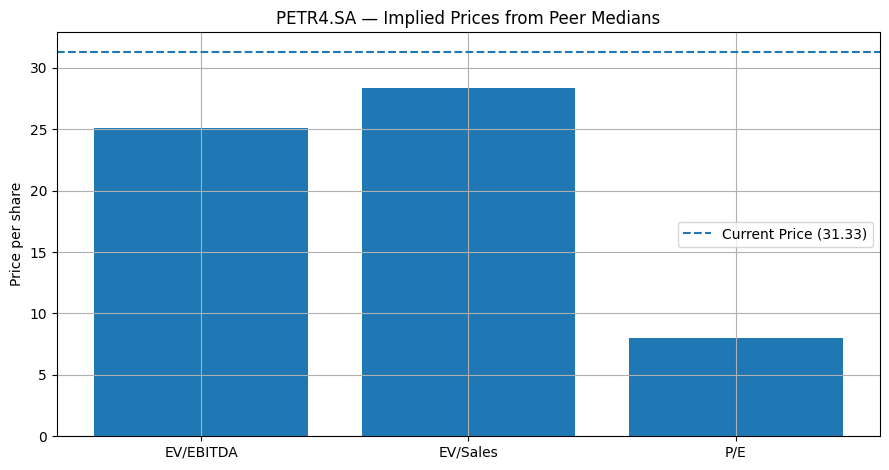

In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import display
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.8)
plt.rcParams["axes.grid"] = True

row = companies.loc[companies["ticker"] == ticker]
if row.empty:
    raise ValueError(f"Ticker {ticker} not found in companies list.")
company_index  = str(row["index"].iloc[0])
company_sector = row["sector"].iloc[0] if pd.notna(row["sector"].iloc[0]) else None

peers_df = companies[
    (companies["index"].str.upper() == company_index.upper()) &
    (companies["sector"] == company_sector) &
    (companies["ticker"] != ticker)
]
peer_tickers = peers_df["ticker"].dropna().str.upper().unique().tolist()

if not peer_tickers:
    peers_df = companies[
        (companies["index"].str.upper() == company_index.upper()) &
        (companies["ticker"] != ticker)
    ]
    peer_tickers = peers_df["ticker"].dropna().str.upper().unique().tolist()

peer_tickers = peer_tickers[:25]
print(f"Peers used: {len(peer_tickers)} (index={company_index}, sector={company_sector or 'N/A'})")

def _to_float(x):
    try: return float(x)
    except Exception: return np.nan

def pull_ratios(tkr: str) -> pd.Series:
    info = {}
    fin  = pd.DataFrame()
    try:
        y = yf.Ticker(tkr)
        info = y.info
        fin  = y.financials if y.financials is not None else pd.DataFrame()
    except Exception:
        pass

    ev_to_sales = _to_float(info.get("enterpriseToRevenue"))
    if np.isnan(ev_to_sales):
        ev = _to_float(info.get("enterpriseValue"))
        sales = np.nan
        if isinstance(fin, pd.DataFrame) and not fin.empty and "Total Revenue" in fin.index:
            col0 = fin.columns[0]
            sales = _to_float(fin.loc["Total Revenue", col0])
        if (not np.isnan(ev)) and (not np.isnan(sales)) and sales > 0:
            ev_to_sales = ev / sales

    return pd.Series({
        "P/E": _to_float(info.get("trailingPE")),
        "P/S": _to_float(info.get("priceToSalesTrailing12Months")),
        "EV/EBITDA": _to_float(info.get("enterpriseToEbitda")),
        "EV/Sales": ev_to_sales
    }, name=tkr)

peer_rows = []
with ThreadPoolExecutor(max_workers=8) as ex:
    futures = {ex.submit(pull_ratios, t): t for t in peer_tickers}
    for fut in as_completed(futures):
        peer_rows.append(fut.result())

peer_ratios = pd.DataFrame(peer_rows)
peer_medians = peer_ratios.median(numeric_only=True)

yt = yf.Ticker(ticker)
info = {}
fin  = pd.DataFrame()
bs   = pd.DataFrame()
try:
    info = yt.info
    fin  = yt.financials if yt.financials is not None else pd.DataFrame()
    bs   = yt.balance_sheet if yt.balance_sheet is not None else pd.DataFrame()
except Exception:
    pass

def pick_latest(df: pd.DataFrame, row_name: str):
    if df is None or df.empty or row_name not in df.index:
        return np.nan
    s = pd.to_numeric(df.loc[row_name], errors="coerce").dropna()
    return float(s.iloc[0]) if not s.empty else np.nan

ebitda = pick_latest(fin, "EBITDA")
sales  = pick_latest(fin, "Total Revenue")
netinc = pick_latest(fin, "Net Income")

total_debt = pick_latest(bs, "Total Debt")
cash_sti   = pick_latest(bs, "Cash Cash Equivalents And Short Term Investments")
if np.isnan(total_debt): total_debt = 0.0
if np.isnan(cash_sti):   cash_sti   = 0.0
net_debt = max(total_debt - cash_sti, 0.0)

shares_out = _to_float(info.get("sharesOutstanding")) or _to_float(info.get("impliedSharesOutstanding"))
px_now = np.nan
try:
    h = yt.history(period="1mo")
    if not h.empty: px_now = float(h["Close"].iloc[-1])
except Exception:
    pass

rows = []

med_ev_ebitda = peer_medians.get("EV/EBITDA", np.nan)
if np.isfinite(med_ev_ebitda) and np.isfinite(ebitda) and ebitda > 0:
    ev = med_ev_ebitda * ebitda
    equity = ev - net_debt
    implied_px = (equity / shares_out) if shares_out and shares_out > 0 else np.nan
    rows.append(["EV/EBITDA", med_ev_ebitda, ebitda, ev, equity, implied_px])

med_ev_sales = peer_medians.get("EV/Sales", np.nan)
med_ps       = peer_medians.get("P/S", np.nan)

if np.isfinite(sales) and sales > 0:
    if np.isfinite(med_ev_sales):
        ev = med_ev_sales * sales
        equity = ev - net_debt
        implied_px = (equity / shares_out) if shares_out and shares_out > 0 else np.nan
        rows.append(["EV/Sales", med_ev_sales, sales, ev, equity, implied_px])
    elif np.isfinite(med_ps):
        mcap = med_ps * sales
        implied_px = (mcap / shares_out) if shares_out and shares_out > 0 else np.nan
        rows.append(["P/S", med_ps, sales, np.nan, mcap, implied_px])

med_pe = peer_medians.get("P/E", np.nan)
if np.isfinite(med_pe) and np.isfinite(netinc) and netinc > 0:
    mcap = med_pe * netinc
    implied_px = (mcap / shares_out) if shares_out and shares_out > 0 else np.nan
    rows.append(["P/E", med_pe, netinc, np.nan, mcap, implied_px])

if not rows:
    raise RuntimeError("Insufficient data to compute any market-implied valuation.")

imp_cols = ["Method", "Peer Median", "Company Metric", "Implied EV", "Implied Equity", "Implied Price"]
implied = pd.DataFrame(rows, columns=imp_cols)
implied["Premium / (Discount) vs Price"] = (implied["Implied Price"] / px_now - 1.0) if np.isfinite(px_now) else np.nan

fmt = {
    "Peer Median": "{:.2f}",
    "Company Metric": "{:,.0f}",
    "Implied EV": "{:,.0f}",
    "Implied Equity": "{:,.0f}",
    "Implied Price": "{:,.2f}",
    "Premium / (Discount) vs Price": "{:.1%}"
}
print(f"Current Price: {px_now:.2f}" if np.isfinite(px_now) else "Current Price: N/A")
display(implied.style.format(fmt, na_rep="—").set_caption(f"Market-Implied Valuation — {ticker} (index {company_index}, sector {company_sector})"))

try:
    fig, ax = plt.subplots()
    y = implied["Implied Price"].values
    x = implied["Method"].values
    ax.bar(x, y)
    if np.isfinite(px_now):
        ax.axhline(px_now, linestyle="--", label=f"Current Price ({px_now:.2f})")
        ax.legend()
    ax.set_ylabel("Price per share")
    ax.set_title(f"{ticker} — Implied Prices from Peer Medians")
    plt.tight_layout()
    plt.show()
except Exception:
    pass

# 8. Equity-Side Valuation: Dividends & FCFE

DCF prices the **business** (EV); this step prices the **equity** directly. We run two lenses:

- **Dividend Discount (DDM):** for names that reliably distribute cash. We use the last annual dividend and a conservative growth anchor (capped by long-run nominal growth).  
- **Free Cash Flow to Equity (FCFE):** for firms that retain cash or buy back shares. We estimate FCFE from statements (≈ **CFO – CAPEX + net borrowing**) and apply a Gordon growth setup with equity discount rate.

Both are currency-consistent (they use the **local cost of equity** from Step 5). If inputs are missing (e.g., no dividends, no debt flow), the method is skipped rather than forcing a bad number.

/tmp/ipython-input-3056388670.py:56: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  div_yr = div.resample("Y").sum()


,Method,Base (per share),Growth g,Ke,Implied Price,Premium / (Discount)
0,DDM (Gordon),2.33,0.00%,8.18%,28.46,-9.1%
1,FCFE (Gordon),"39,900,000,000.00",4.80%,8.18%,226.95,624.4%



Current Price: 31.33


,Ke=6.18%,Ke=8.18%,Ke=10.18%
g=0.00%,37.67,28.46,22.87
g=0.50%,41.19,30.47,24.18


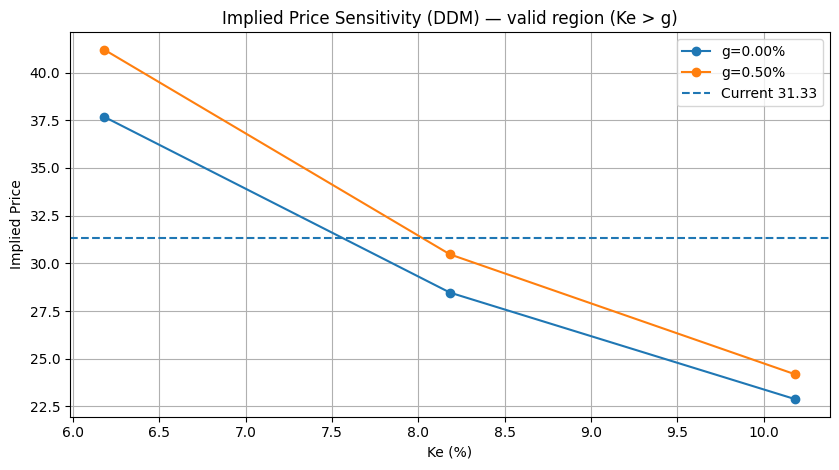

In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
from IPython.display import display
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8.5, 4.8)
plt.rcParams["axes.grid"] = True

KE = globals().get("KE_LOCAL", None)
if KE is None or not np.isfinite(KE):
    WACC_fallback = globals().get("WACC", 0.11)
    KE = float(WACC_fallback) + 0.01 if np.isfinite(WACC_fallback) else 0.12

g_anchor = globals().get("g_nominal", 0.03)
g_anchor = float(g_anchor) if np.isfinite(g_anchor) else 0.03

yt = yf.Ticker(ticker)

price_now = np.nan
try:
    h = yt.history(period="1mo")
    if not h.empty:
        price_now = float(h["Close"].iloc[-1])
except Exception:
    pass

info = {}
fin = pd.DataFrame()
cf  = pd.DataFrame()
try:
    info = yt.info
    fin  = yt.financials if yt.financials is not None else pd.DataFrame()
    cf   = yt.cashflow if yt.cashflow is not None else pd.DataFrame()
except Exception:
    pass

def _pick_latest(df, row_name):
    if df is None or df.empty or row_name not in df.index:
        return np.nan
    s = pd.to_numeric(df.loc[row_name], errors="coerce").dropna()
    return float(s.iloc[0]) if not s.empty else np.nan

shares_out = info.get("sharesOutstanding") or info.get("impliedSharesOutstanding")
try:
    shares_out = float(shares_out)
except Exception:
    shares_out = np.nan

ddm_price = np.nan
ddm_inputs = {}

try:
    div = yt.dividends
    if div is not None and not div.empty:
        div_yr = div.resample("Y").sum()
        div_yr = div_yr.dropna().tail(5)
        D0 = float(div_yr.iloc[-1]) if not div_yr.empty else np.nan

        if len(div_yr) >= 2 and div_yr.iloc[0] > 0 and div_yr.iloc[-1] > 0:
            n = len(div_yr) - 1
            g_div = (div_yr.iloc[-1] / div_yr.iloc[0]) ** (1/n) - 1
        else:
            g_div = g_anchor * 0.7

        g_div = float(np.clip(g_div, 0.00, max(g_anchor, 0.0)))
        if KE > g_div and D0 > 0:
            D1 = D0 * (1.0 + g_div)
            ddm_price = D1 / (KE - g_div)
            ddm_inputs = {"D0": D0, "g": g_div, "Ke": KE}
except Exception:
    pass

fcfe_price = np.nan
fcfe_inputs = {}

def _pick_cashflow(row_name):
    return _pick_latest(cf, row_name)

CFO   = _pick_cashflow("Operating Cash Flow")
CAPEX = _pick_cashflow("Capital Expenditure")
if np.isfinite(CAPEX):
    CAPEX = -float(CAPEX)

debt_issued   = _pick_cashflow("Issuance Of Debt")
debt_repaid   = _pick_cashflow("Repayment Of Debt")
if not np.isfinite(debt_issued): debt_issued = 0.0
if not np.isfinite(debt_repaid): debt_repaid = 0.0
net_borrowing = float(debt_issued) - float(debt_repaid)

if np.isfinite(CFO) and np.isfinite(CAPEX):
    FCFE_ttm = float(CFO) - float(CAPEX) + float(net_borrowing)
    g_fcfe = min(max(g_anchor * 0.8, 0.0), max(KE - 0.01, 0.0))
    if FCFE_ttm > 0 and KE > g_fcfe and np.isfinite(shares_out) and shares_out > 0:
        FCFE1 = FCFE_ttm * (1.0 + g_fcfe)
        equity_val = FCFE1 / (KE - g_fcfe)
        fcfe_price = equity_val / shares_out
        fcfe_inputs = {"FCFE_ttm": FCFE_ttm, "g": g_fcfe, "Ke": KE}

rows = []
if np.isfinite(ddm_price):
    prem = (ddm_price / price_now - 1.0) if np.isfinite(price_now) else np.nan
    rows.append(["DDM (Gordon)", ddm_inputs.get("D0"), ddm_inputs.get("g"), ddm_inputs.get("Ke"), ddm_price, prem])
if np.isfinite(fcfe_price):
    prem = (fcfe_price / price_now - 1.0) if np.isfinite(price_now) else np.nan
    rows.append(["FCFE (Gordon)", fcfe_inputs.get("FCFE_ttm"), fcfe_inputs.get("g"), fcfe_inputs.get("Ke"), fcfe_price, prem])

if rows:
    out = pd.DataFrame(rows, columns=["Method", "Base (per share)", "Growth g", "Ke", "Implied Price", "Premium / (Discount)"])
    display(out.style.format({
        "Base (per share)": "{:,.2f}",
        "Growth g": "{:.2%}",
        "Ke": "{:.2%}",
        "Implied Price": "{:,.2f}",
        "Premium / (Discount)": "{:.1%}"
    }, na_rep="—").set_caption(f"Equity Valuation — {ticker}"))
else:
    print("No valid DDM or FCFE inputs available (dividends/FCFE missing).")

if np.isfinite(price_now):
    print(f"\nCurrent Price: {price_now:.2f}")

chosen = None
base = None
if np.isfinite(ddm_price):
    chosen = "DDM"
    base = ddm_inputs.get("D0")
    g0   = ddm_inputs.get("g")
elif np.isfinite(fcfe_price):
    chosen = "FCFE"
    base = fcfe_inputs.get("FCFE_ttm")
    g0   = fcfe_inputs.get("g")

if chosen and np.isfinite(base) and base > 0:
    ke_grid = np.array([KE - 0.02, KE, KE + 0.02])
    ke_grid = np.clip(ke_grid, 0.04, 0.30)

    buffer = 0.005
    g_low  = max(g0 - 0.005, 0.0)
    g_mid  = min(g0, ke_grid.min() - buffer)
    g_high = min(g0 + 0.005, ke_grid.min() - buffer/2)
    g_candidates = [g for g in [g_low, g_mid, g_high] if g >= 0]
    g_grid = np.array(sorted({round(g, 6) for g in g_candidates}))

    def price_equity(base_val, g, ke):
        if ke <= g or not np.isfinite(shares_out) or shares_out <= 0:
            return np.nan
        val = (base_val * (1.0 + g)) / (ke - g)
        return val if chosen == "DDM" else val / shares_out

    grid = []
    for g in g_grid:
        row_vals = []
        for ke in ke_grid:
            p = price_equity(base, g, ke)
            if chosen == "FCFE" and np.isfinite(p):
                row_vals.append(p)
            else:
                row_vals.append(p)
        grid.append(row_vals)

    sens = pd.DataFrame(grid,
        index=[f"g={g*100:.2f}%" for g in g_grid],
        columns=[f"Ke={k*100:.2f}%" for k in ke_grid]
    )

    title = f"Implied Price Sensitivity ({chosen}) — valid region (Ke > g)"
    display(sens.style.format("{:,.2f}", na_rep="—").set_caption(title))

    try:
        fig, ax = plt.subplots()
        for i, g in enumerate(g_grid):
            ax.plot(ke_grid*100, sens.iloc[i].values, marker="o", label=f"g={g*100:.2f}%")
        if np.isfinite(price_now):
            ax.axhline(price_now, linestyle="--", label=f"Current {price_now:.2f}")
        ax.set_xlabel("Ke (%)")
        ax.set_ylabel("Implied Price")
        ax.set_title(title)
        ax.legend()
        plt.tight_layout()
        plt.show()
    except Exception:
        pass

# 9. Scenarios & Risk (What moves the valuation?)

No valuation survives first contact with reality unless we stress it. Here we turn the DCF into a **scenario engine**.  
We vary the key drivers — **WACC**, **terminal growth**, **EBIT margin**, **CAPEX and working-capital intensity**, and **starting growth** — and read the price response. The goal is not to find a single “right” number, but to map the **slope of the truth**: which levers matter, how much buffer we have, and where our thesis can break.

,WACC=6.76%,WACC=7.76%,WACC=8.76%
g=5.50%,285.44,158.81,109.95
g=6.00%,470.38,202.46,128.92
g=6.50%,"1,375.68",280.84,156.30


,Driver,Low,Base,High,Range
0,WACC,470.38,202.46,128.92,-341.46
1,Terminal g,158.81,202.46,280.84,122.03
2,EBIT margin,188.47,202.46,216.45,27.98
3,CAPEX/Revenue,222.95,202.46,181.98,-40.97
4,NWC/Revenue,203.05,202.46,201.87,-1.18
5,Start growth,193.44,202.46,211.78,18.34


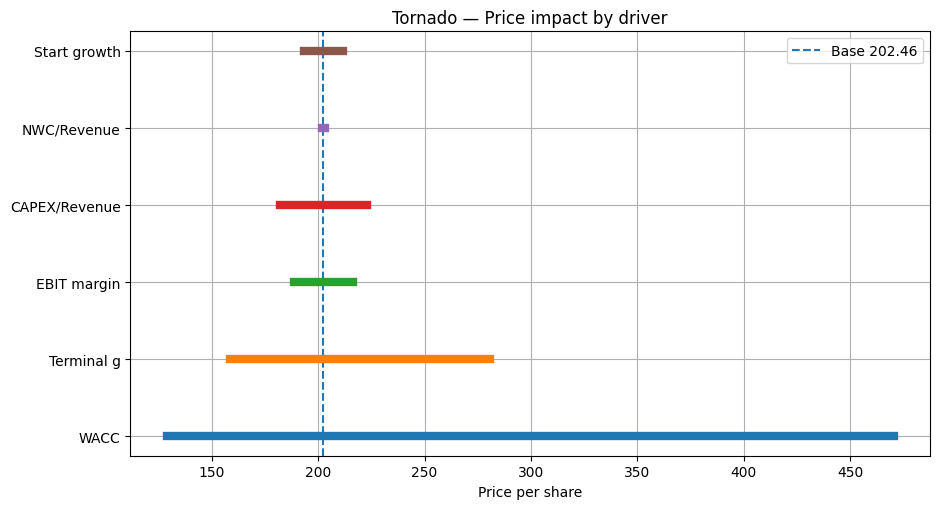

In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
from IPython.display import display
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9.5, 5.2)
plt.rcParams["axes.grid"] = True

def _num(x, default=np.nan):
    try:
        v = float(x);  return v if np.isfinite(v) else default
    except Exception:
        return default

def clamp(v, lo, hi):
    return float(np.clip(v, lo, hi))

def mean_tail(s, n=3):
    s = pd.Series(s, dtype="float64").dropna().tail(n)
    return s.mean() if not s.empty else np.nan

def pick(df, labels):
    if df is None or (isinstance(df, pd.DataFrame) and df.empty):
        return pd.Series(dtype=float)
    for lab in labels:
        if lab in df.columns:
            return pd.to_numeric(df[lab], errors="coerce")
    return pd.Series([np.nan]*len(df), index=df.index if hasattr(df, "index") else None, dtype=float)

def prep(df, last=6):
    if df is None or (isinstance(df, pd.DataFrame) and df.empty): return pd.DataFrame()
    out = df.T.copy()
    try: out.index = pd.to_datetime(out.index).year
    except: pass
    out = out.sort_index().tail(last)
    for c in out.columns: out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def last_non_null(series_like, default=np.nan):
    """Return last non-null numeric value or default; never raises IndexError."""
    try:
        s = pd.to_numeric(pd.Series(series_like), errors="coerce").dropna()
        return float(s.iloc[-1]) if not s.empty else default
    except Exception:
        # If it's already a Pandas Series:
        try:
            s = pd.to_numeric(series_like, errors="coerce").dropna()
            return float(s.iloc[-1]) if not s.empty else default
        except Exception:
            return default

def get_last_revenue(yt, fin_annual):
    """
    Try annual 'Total Revenue' → if missing, sum last 4 quarters →
    fallback to info['totalRevenue'].
    """
    rev_series = pick(fin_annual, ["Total Revenue","Revenue"]).dropna()
    if not rev_series.empty:
        return float(rev_series.iloc[-1])

    try:
        qfin = yt.quarterly_financials
        if isinstance(qfin, pd.DataFrame) and not qfin.empty and "Total Revenue" in qfin.index:
            q = pd.to_numeric(qfin.loc["Total Revenue"], errors="coerce").dropna().head(4)
            if not q.empty:
                return float(q.sum())
    except Exception:
        pass

    try:
        info = yt.info or {}
        tr = info.get("totalRevenue")
        if tr is not None and np.isfinite(_num(tr)):
            return float(tr)
    except Exception:
        pass

    return np.nan

yt = yf.Ticker(ticker)

fin = globals().get("fin")
bs  = globals().get("bs")
cf  = globals().get("cf")
if fin is None or bs is None or cf is None or fin.empty or bs.empty:
    fin = prep(yt.financials, 6)
    bs  = prep(yt.balance_sheet, 6)
    cf  = prep(yt.cashflow, 6)

revenue   = pick(fin, ["Total Revenue","Revenue"])
ebit      = pick(fin, ["Operating Income","EBIT","OperatingIncome"])
ebitda    = pick(fin, ["EBITDA"])
depr      = pick(fin, ["Reconciled Depreciation","Depreciation & Amortization","Depreciation"])

if ebit.isna().all() and not ebitda.isna().all() and not depr.isna().all():
    ebit = (ebitda - depr)

curr_assets = pick(bs, ["Total Current Assets"])
curr_liab  = pick(bs, ["Total Current Liabilities"])
cash_sti   = pick(bs, ["Cash Cash Equivalents And Short Term Investments","Cash And Cash Equivalents"]).fillna(0)
total_debt = pick(bs, ["Total Debt","Short Long Term Debt","Long Term Debt"]).fillna(0)
nwc = (curr_assets - cash_sti) - curr_liab

ebit_margin_base = globals().get("ebit_margin", mean_tail((ebit/revenue).replace([np.inf,-np.inf], np.nan), 3))
ebit_margin_base = clamp(_num(ebit_margin_base, 0.15), -0.10, 0.40)

da_to_rev_base   = globals().get("da_to_rev", mean_tail((depr/revenue).replace([np.inf,-np.inf], np.nan), 3))
da_to_rev_base   = clamp(_num(da_to_rev_base, 0.04), 0.00, 0.10)

capex_cf = pick(cf, ["Capital Expenditure","Investments"])
capex_to_rev_base = globals().get("capex_to_rev",
                                  mean_tail((-capex_cf/revenue).replace([np.inf,-np.inf], np.nan), 3))
capex_to_rev_base = clamp(_num(capex_to_rev_base, 0.06), 0.00, 0.20)

nwc_to_rev_base  = globals().get("nwc_to_rev", mean_tail((nwc/revenue).replace([np.inf,-np.inf], np.nan), 3))
nwc_to_rev_base  = clamp(_num(nwc_to_rev_base, 0.05), -0.10, 0.40)

tax_rate_base = clamp(_num(globals().get("tax_rate")), 0.10, 0.40) if np.isfinite(_num(globals().get("tax_rate"))) else 0.25

rev0 = get_last_revenue(yt, fin)
if not np.isfinite(rev0) or rev0 <= 0:
    raise RuntimeError("Cannot run scenarios: revenue is unavailable for this ticker (annual, quarterly, and info fallbacks all missing). Try another ticker or re-run after data refresh.")

rev_hist = pick(fin, ["Total Revenue","Revenue"]).dropna()
if len(rev_hist) >= 2:
    years = max(rev_hist.index[-1] - rev_hist.index[0], len(rev_hist)-1)
    g0_base = (rev_hist.iloc[-1]/rev_hist.iloc[0])**(1/max(years,1)) - 1
else:
    g0_base = np.nan
g0_base = clamp(_num(g0_base, globals().get("g_nominal", 0.03) + 0.03), -0.10, 0.25)

net_debt = max(
    last_non_null(total_debt, 0.0) - last_non_null(cash_sti, 0.0),
    0.0
)
info = {}
try: info = yt.info
except: pass
shares_out = _num(info.get("sharesOutstanding") or info.get("impliedSharesOutstanding"))

def dcf_price(
    WACC, g,
    dm=0.00, dcapex=0.00, dnwc=0.00, d_g0=0.00
):
    """
    Re-run a 5y FCFF DCF using baseline drivers + adjustments:
      dm = ΔEBIT margin (abs, e.g., +0.02 = +200 bps)
      dcapex = ΔCAPEX/Revenue (abs)
      dnwc   = ΔNWC/Revenue (abs)
      d_g0   = Δstarting growth (abs)
    Returns implied price per share (np.nan if shares unknown).
    """
    if WACC <= g:
        g = max(min(g, WACC - 0.01), 0.0)

    ebit_margin = clamp(ebit_margin_base + dm, -0.10, 0.45)
    capex_int   = clamp(capex_to_rev_base + dcapex, 0.00, 0.25)
    nwc_int     = clamp(nwc_to_rev_base + dnwc, -0.10, 0.50)
    da_int      = da_to_rev_base

    g0 = clamp(g0_base + d_g0, -0.10, 0.30)
    growth_path = np.linspace(g0, g, 5)

    nwc_prev = last_non_null(nwc, default=rev0 * nwc_int)

    rev_t = rev0
    fcff_list = []
    for gy in growth_path:
        rev_t  = rev_t * (1.0 + float(gy))
        ebit_t = rev_t * ebit_margin
        da_t   = rev_t * da_int
        nopat  = ebit_t * (1.0 - tax_rate_base)
        capex  = rev_t * capex_int
        nwc_t  = rev_t * nwc_int
        d_nwc  = (nwc_t - nwc_prev) if np.isfinite(nwc_t) and np.isfinite(nwc_prev) else 0.0
        nwc_prev = nwc_t if np.isfinite(nwc_t) else nwc_prev
        fcff     = nopat + da_t - capex - d_nwc
        fcff_list.append(fcff)

    dfs = np.array([1.0/((1.0+WACC)**t) for t in [1,2,3,4,5]])
    pv_fcff = np.dot(fcff_list, dfs)
    tv = fcff_list[-1] * (1.0 + g) / (WACC - g)
    pv_tv = tv * dfs[-1]
    ev = pv_fcff + pv_tv
    eq = ev - net_debt
    if shares_out and shares_out > 0:
        return eq / shares_out
    return np.nan

WACC_base = _num(globals().get("WACC"), 0.10)
g_base    = _num(globals().get("g_nominal"), 0.03)

wacc_grid = np.sort(np.array([WACC_base-0.01, WACC_base, WACC_base+0.01]))
buffer = 0.005
g_low  = max(g_base - 0.005, 0.0)
g_mid  = min(g_base, wacc_grid.min() - buffer)
g_high = min(g_base + 0.005, wacc_grid.min() - buffer/2)
g_grid = np.array(sorted({round(g,6) for g in [g_low, g_mid, g_high]}))

grid_prices = []
for g in g_grid:
    row_vals = []
    for w in wacc_grid:
        row_vals.append(dcf_price(w, g))
    grid_prices.append(row_vals)

sens_grid = pd.DataFrame(
    grid_prices,
    index=[f"g={g*100:.2f}%" for g in g_grid],
    columns=[f"WACC={w*100:.2f}%" for w in wacc_grid]
)
display(sens_grid.style.format("{:,.2f}").set_caption("DCF Implied Price — Scenario Grid (valid region WACC > g)"))

base_price = dcf_price(WACC_base, g_base)
shocks = [
    ("WACC",         {"dWACC": -0.01}, {"dWACC": +0.01}),
    ("Terminal g",   {"dg":   -0.005}, {"dg":   +0.005}),
    ("EBIT margin",  {"dm":   -0.02},  {"dm":   +0.02}),
    ("CAPEX/Revenue",{"dcap": -0.02},  {"dcap": +0.02}),
    ("NWC/Revenue",  {"dnwc": -0.01},  {"dnwc": +0.01}),
    ("Start growth", {"dg0":  -0.02},  {"dg0":  +0.02}),
]

def eval_shock(left, right):
    wL = WACC_base + left.get("dWACC", 0.0)
    wR = WACC_base + right.get("dWACC", 0.0)
    gL = g_base    + left.get("dg", 0.0)
    gR = g_base    + right.get("dg", 0.0)
    pL = dcf_price(wL, gL, dm=left.get("dm",0.0), dcapex=left.get("dcap",0.0), dnwc=left.get("dnwc",0.0), d_g0=left.get("dg0",0.0))
    pR = dcf_price(wR, gR, dm=right.get("dm",0.0), dcapex=right.get("dcap",0.0), dnwc=right.get("dnwc",0.0), d_g0=right.get("dg0",0.0))
    return pL, pR

rows = []
for label, left, right in shocks:
    pL, pR = eval_shock(left, right)
    rows.append([label, pL, base_price, pR, (pR - pL)])

tornado = pd.DataFrame(rows, columns=["Driver","Low","Base","High","Range"])
display(tornado.style.format({"Low":"{:,.2f}","Base":"{:,.2f}","High":"{:,.2f}","Range":"{:,.2f}"})
        .set_caption("One-at-a-time Sensitivities (Price per share)"))

try:
    fig, ax = plt.subplots()
    y = tornado["Driver"]
    xlow = tornado["Low"]
    xhigh = tornado["High"]
    if np.isfinite(base_price):
        ax.axvline(base_price, linestyle="--", label=f"Base {base_price:,.2f}")
    for i in range(len(y)):
        ax.plot([xlow[i], xhigh[i]], [i, i], lw=6)
    if np.isfinite(base_price):
        ax.legend()
    ax.set_yticks(range(len(y))); ax.set_yticklabels(y)
    ax.set_xlabel("Price per share")
    ax.set_title("Tornado — Price impact by driver")
    plt.tight_layout(); plt.show()
except Exception:
    pass

# Conclusions and Insights

This single-company analysis started with a simple prompt — **pick a ticker** — and unfolded into a full valuation narrative. Along the way we showed that rigorous finance doesn’t have to be opaque: every number has a provenance, every assumption has a guardrail, and every conclusion is tested against alternatives.

**From Ticker to Thesis**  
We began by resolving the company’s identity within a curated universe (S&P 500, IPC, Ibovespa), mapping to Yahoo Finance symbols and detecting **index + sector** to frame the right peer set. That early discipline mattered: the peers determined our market context, and the market context determined what “cheap” or “expensive” could even mean.

**Economics over Optics**  
Rather than copy headline figures, we reconstructed the **income statement, balance sheet, and cash flow** into the drivers that actually power valuation: operating margins, D&A, CAPEX intensity, and working capital needs. Where disclosures were thin, we used conservative defaults and made the gaps visible; when data was rich, the model leaned on it. The result was an analysis that stays usable across geographies and reporting quirks.

**Comparable Multiples, in Context**  
With a peer cohort anchored in the same **index and sector**, we translated medians for **EV/EBITDA, EV/Sales, and P/E** into **implied enterprise and equity values** for our company. This wasn’t a beauty contest; it was a market-implied cross-check. If the market pays 9–10× EBITDA for peers and our economics are similar, the implied price tells us where sentiment and fundamentals meet.

**Intrinsic Value, Not Just Benchmarks**  
Markets can be noisy, so we also priced the **business** directly via a five-year **FCFF DCF**. The discount rate (**WACC**) and terminal growth (**g**) were **macro-consistent** by construction, tying local inflation and long-run real growth to the company’s country while guarding against the classic \( g \geq WACC \) mistake. On the equity side, **DDM** and **FCFE** supplied parallel reads for dividend payers and buyback-driven names.

**Risk Mapped, Not Assumed Away**  
A dedicated **scenario engine** made the sensitivities explicit. We didn’t hide behind point estimates; we showed how price bends when **WACC, g, margin, CAPEX, and working capital** shift. The tornado view surfaced which levers truly move value — a practical guide for diligence and for the “what could break the thesis?” conversation.

**What This Demonstrates**  
Taken together, the project shows an ability to:  
- Turn messy, live data into analysis-ready fundamentals across **U.S., Mexico, and Brazil**.  
- Triangulate **market-implied** and **intrinsic** valuations with transparent assumptions.  
- Build models that **fail gracefully** and **explain themselves** when inputs are missing.  
- Communicate results with clean tables, clear charts, and narrative that reads like a memo, not a dump of numbers.

**Final Reflection**  
There is no single “correct” valuation — only a range that tightens as evidence accumulates. By combining peer context, macro-aware discounting, cash-flow logic, and disciplined scenarios, we turned a ticker into a defensible view of value. That’s the real outcome here: an analysis you can debate, adjust, and trust enough to act on — and a reusable blueprint for the next company on the list.